In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re
import scipy.stats as stats
from itertools import combinations
import random
import io
import string
from bioinfokit import analys, visuz
import pickle


from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_for_CAR_annotation as ca
import functions_OVA_annotation as oa

/tmp/ipykernel_1658232/3344689522.py:30: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(ca)
importlib.reload(oa)

<module 'functions_OVA_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py'>

In [ ]:
bioc = ro.packages.importr('BiocManager') 
# bioc.install('edgeR')
bioc.install('DESeq2')

* installing *source* package ‘DESeq2’ ...
** using staged installation
** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 14.1.0-0) 14.1.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/s377963/mambaforge/envs/scanpy/lib/R/include" -DNDEBUG  -I'/home/s377963/mambaforge/envs/scanpy/lib/R/library/Rcpp/include' -I'/home/s377963/mambaforge/envs/scanpy/lib/R/library/RcppArmadillo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/s377963/mambaforge/envs/scanpy/include -I/home/s377963/mambaforge/envs/scanpy/include -Wl,-rpath-link,/home/s377963/mambaforge/envs/scanpy/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/s377963/mambaforge/envs/scanpy/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1723488709275/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/home/s377963/mambaforge/envs/scanpy=/usr/local/src/conda-prefix  -c DESeq2.cpp -o DESeq2.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/s377963/mambaforge/envs/scanpy/lib/R/includ

installing to /home/s377963/mambaforge/envs/scanpy/lib/R/library/00LOCK-DESeq2/00new/DESeq2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (DESeq2)


Update all/some/none? [a/s/n]: 

array(['DESeq2'], dtype='<U6')

: 

: 

In [5]:
seurat = ro.packages.importr('Seurat')
edgeR = ro.packages.importr('edgeR')
DESeq2 = ro.packages.importr('DESeq2')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

# Load Data

In [6]:
#import data

# adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
# adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
# adata_TIL_only = diff_diff_adata_qc[adata_qc.obs.Location != 'dLN']
# adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
# adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [7]:
non_annotated = [adata_pure_TC_annotated, adata_only_annotatedTC]

In [8]:
for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_1658232/939101785.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


# Determine cytokine profile

In [ ]:
adata_only_annotatedTC.obs.condition
# adata_only_annotatedTC.obs.day

AAACCTGCATGAAGTA-1_1     C
AAACCTGGTAGGACAC-1_1    DM
AAACGGGAGAAACCTA-1_1     C
AAACGGGAGCAACGGT-1_1     P
AAAGCAAAGGTGATTA-1_1    DM
                        ..
TTGCGTCTCAAGAAGT-1_9    DM
TTGGAACGTTAAGTAG-1_9     P
TTTATGCGTCTTGCGG-1_9    DM
TTTATGCTCCACGCAG-1_9     P
TTTGGTTTCCAAAGTC-1_9     C
Name: condition, Length: 3456, dtype: category
Categories (3, object): ['C', 'DM', 'P']

: 

: 

In [9]:
# Comprehensive list of cytokines categorized by function
cytokine_genes = [
    # Pro-Inflammatory Cytokines
    "Il1a", "Il1b", "Il18", "Il33", "Il36a", "Il36b", "Il36g", "Il37", "Il38",
    "Tnf", "Lta", "Baff", "April", "Il6", "Il17a", "Il17b", "Il17c", "Il17d", "Il17e", "Il17f",
    "Il12a", "Il12b", "Il23a", "Il27", "Il35",
    
    # Anti-Inflammatory Cytokines
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Chemokines (CC family)
    "Ccl1", "Ccl2", "Ccl3", "Ccl4", "Ccl5", "Ccl7", "Ccl8", "Ccl11", "Ccl13",
    "Ccl17", "Ccl18", "Ccl19", "Ccl20", "Ccl21", "Ccl22", "Ccl25", "Ccl27",
    
    # Chemokines (CXC family)
    "Cxcl1", "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl8", "Cxcl9", "Cxcl10", "Cxcl11",
    "Cxcl12", "Cxcl13", "Cxcl16",
    
    # Other Chemokines
    "Xcl1", "Xcl2", "Cx3cl1",
    
    # Interferons
    "Ifna1", "Ifna2", "Ifna4", "Ifna5", "Ifna6", "Ifna7", "Ifna9", "Ifna10", "Ifna11", "Ifna13",
    "Ifnb1", "Ifne", "Ifnk", "Ifnw1",
    "Ifng",
    "Ifnl1", "Ifnl2", "Ifnl3",
    
    # Growth Factors
    "Csf2", "Csf3", "Csf1", "Egf", "Vegfa", "Vegfb", "Vegfc", "Fgf1", "Fgf2",
    "Pdgfa", "Pdgfb", "Pdgfc", "Pdgfd", "Hgf", "Igf1", "Igf2",
    
    # T Cell-Derived Cytokines
    "Il2", "Il4", "Il5", "Il9", "Il13", "Il21", "Il22", "Il25",
    
    # Regulatory (Treg)
    "Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il35",
    
    # Other Cytokines
    "Spp1", "Il24", "Il26"
]

# If you just need a flat list of all cytokines:
# all_cytokines = sum([v if isinstance(v, list) else sum(v.values(), []) for v in cytokines.values()], [])

# Print all cytokines
# print(all_cytokines)


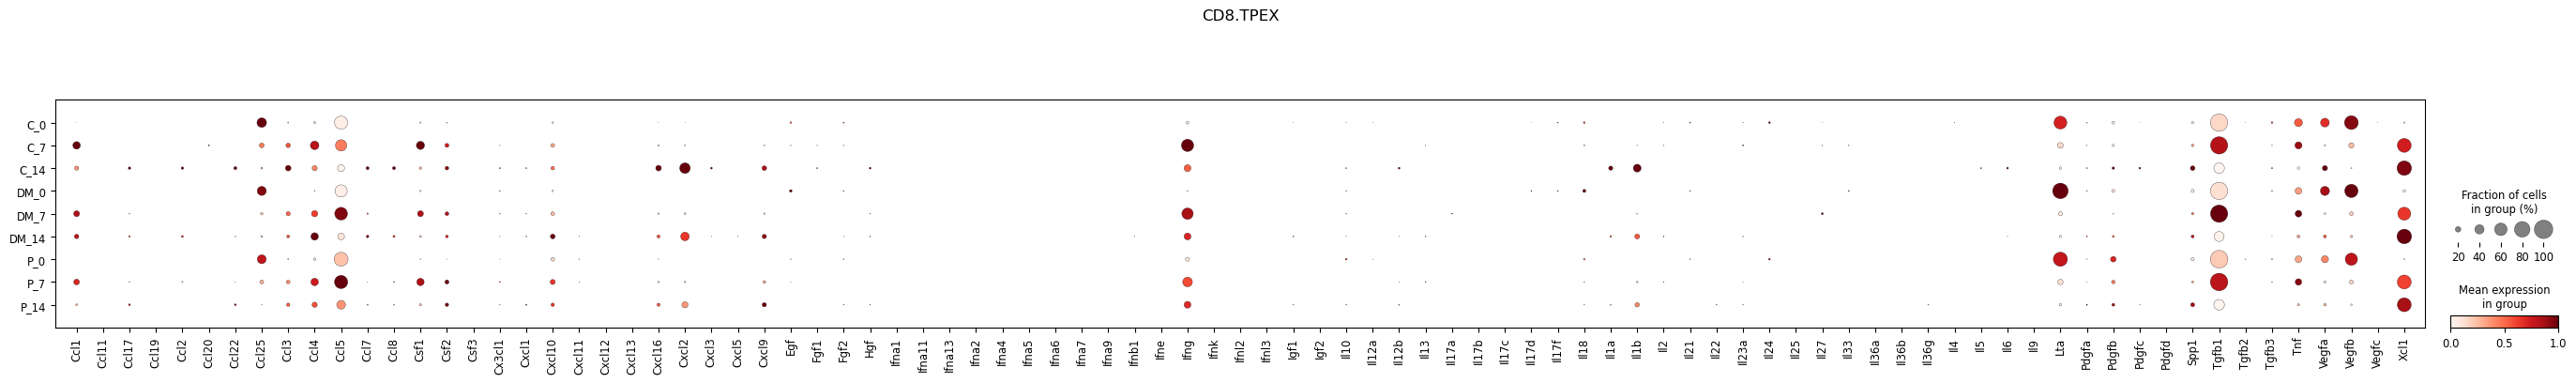

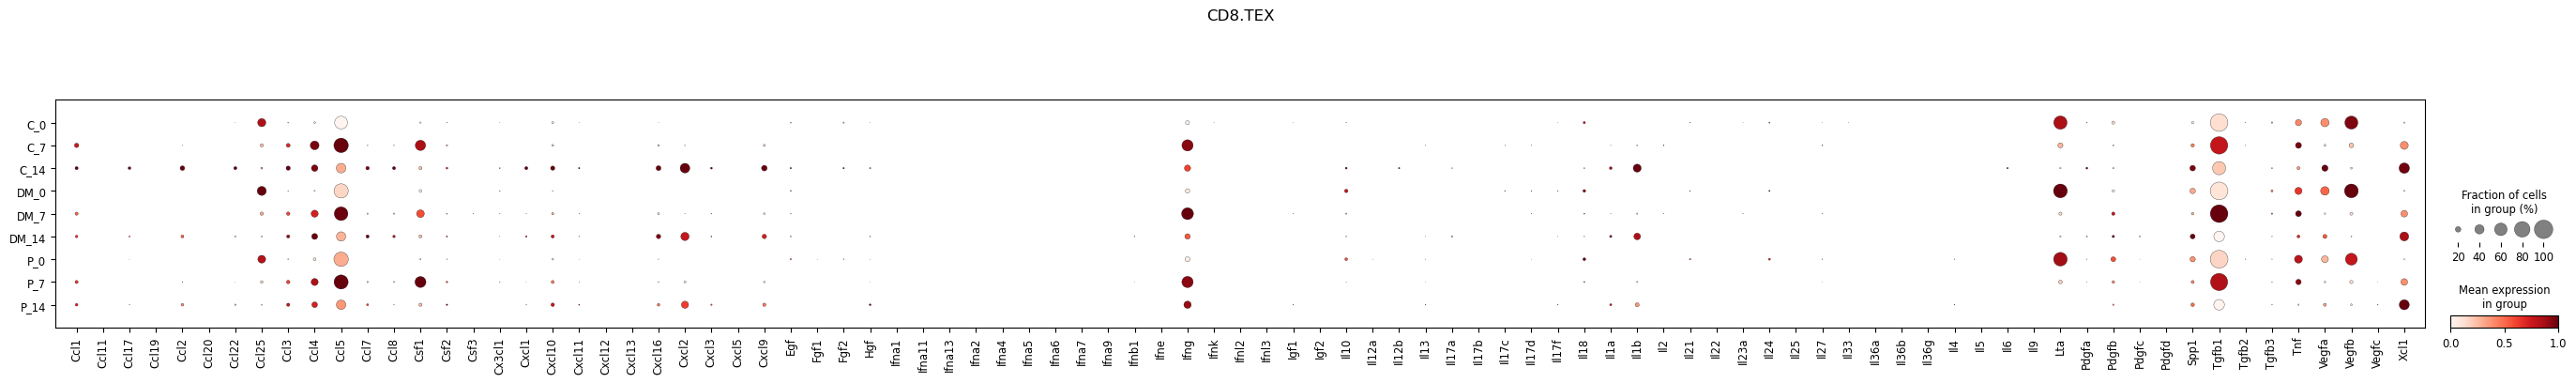

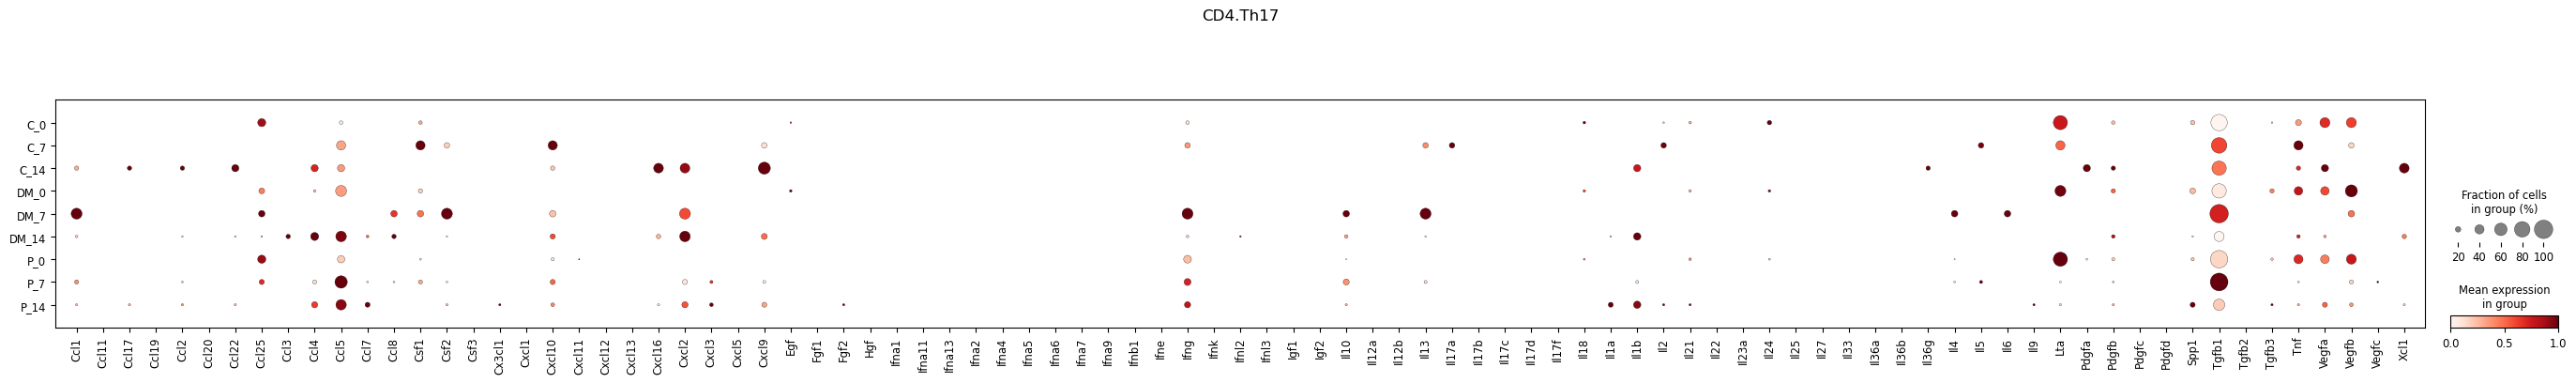

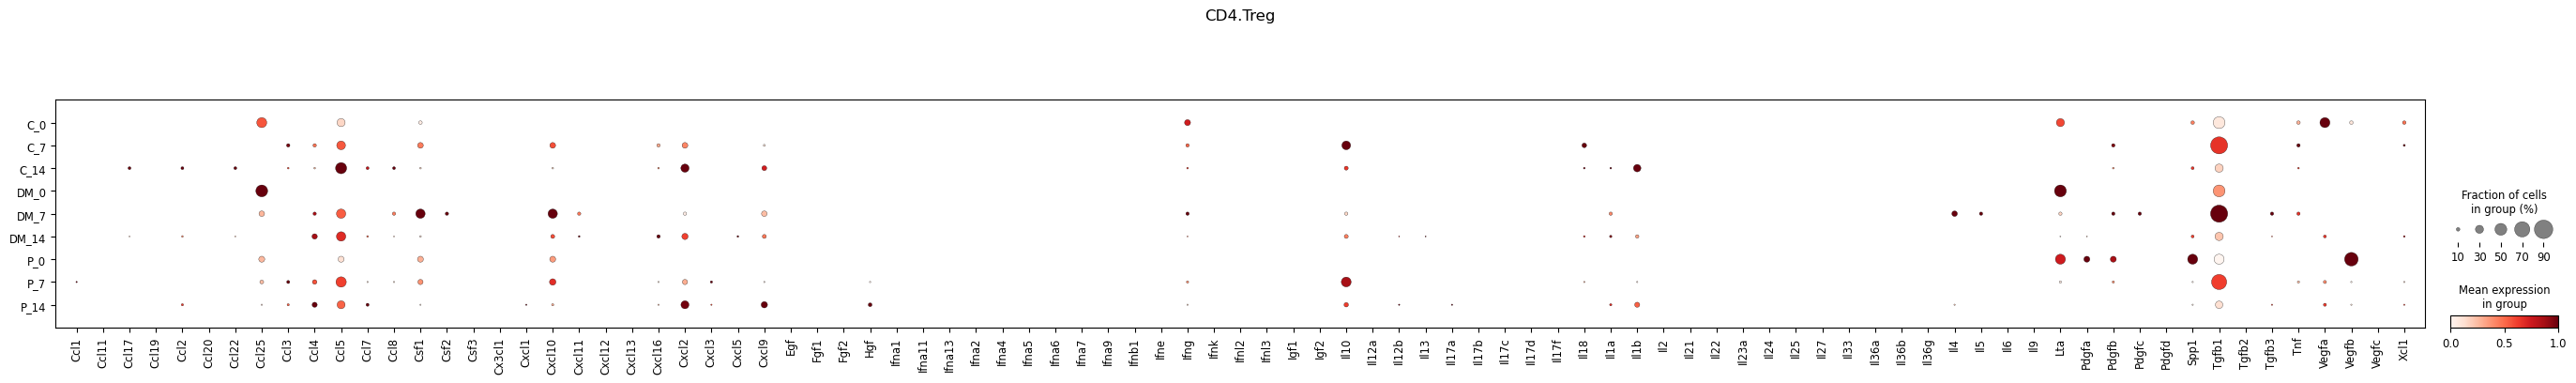

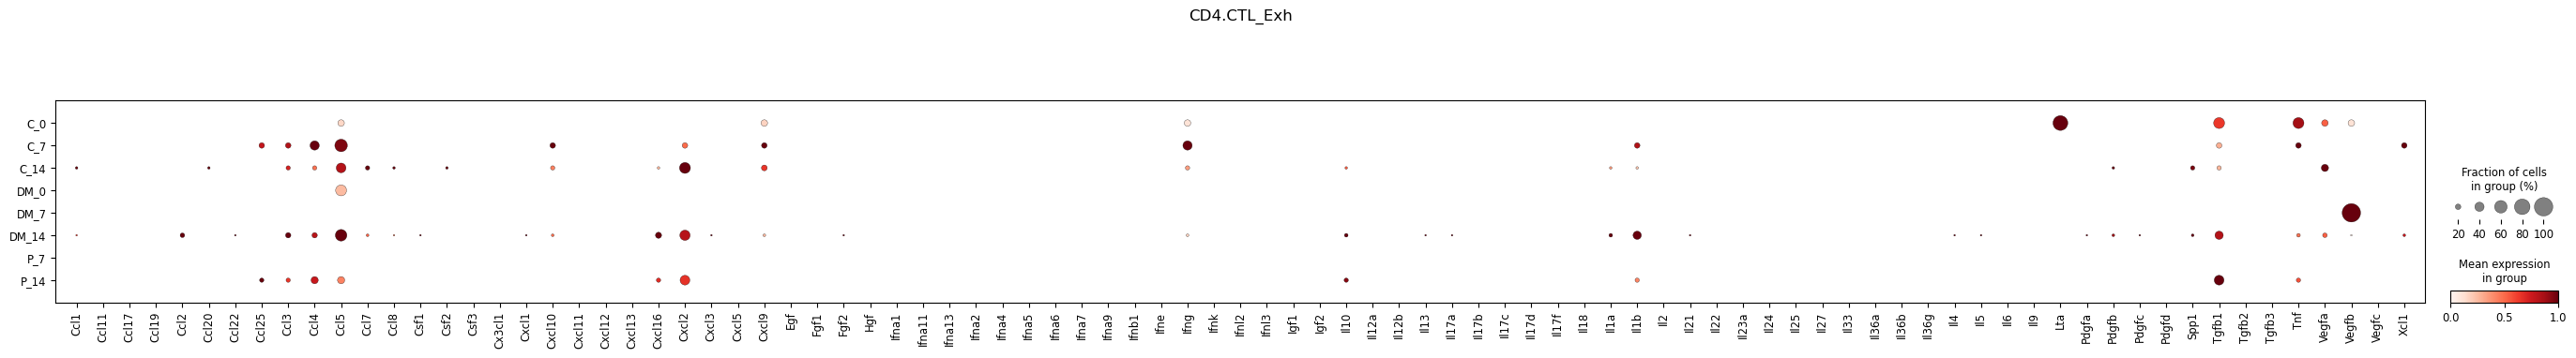

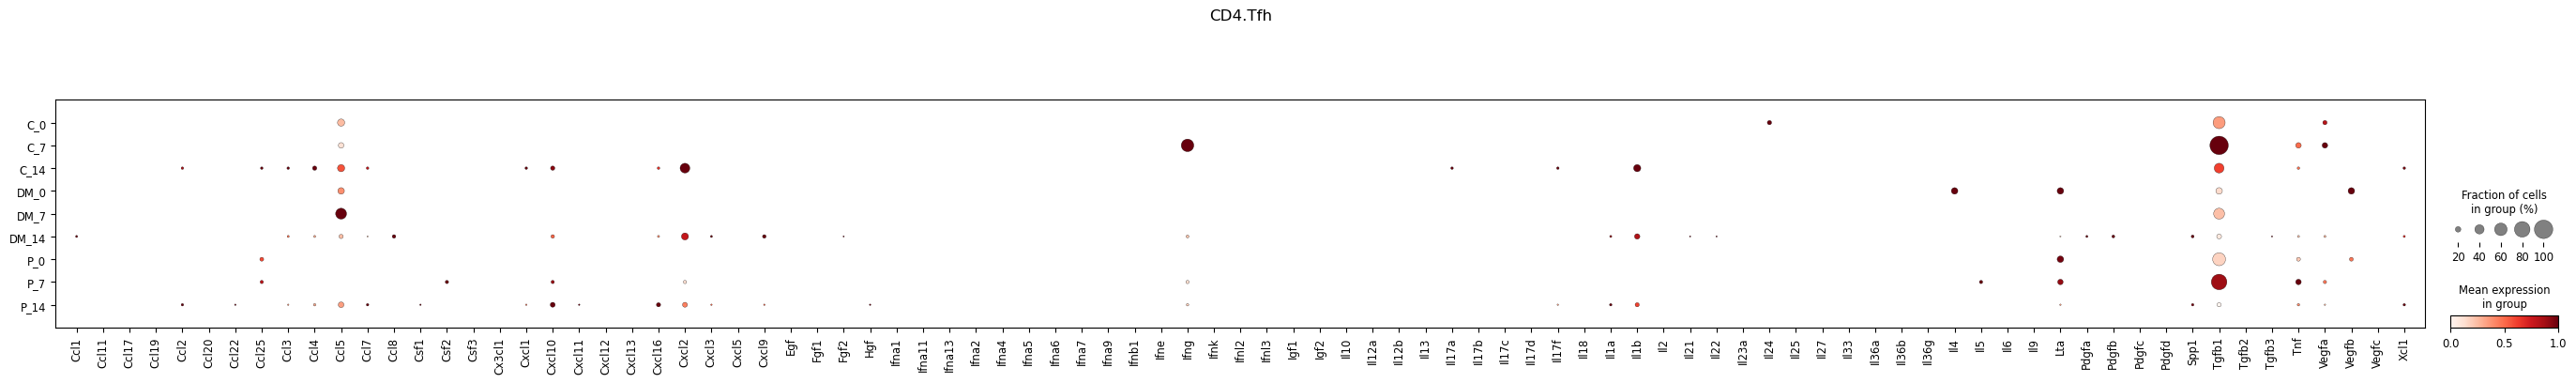

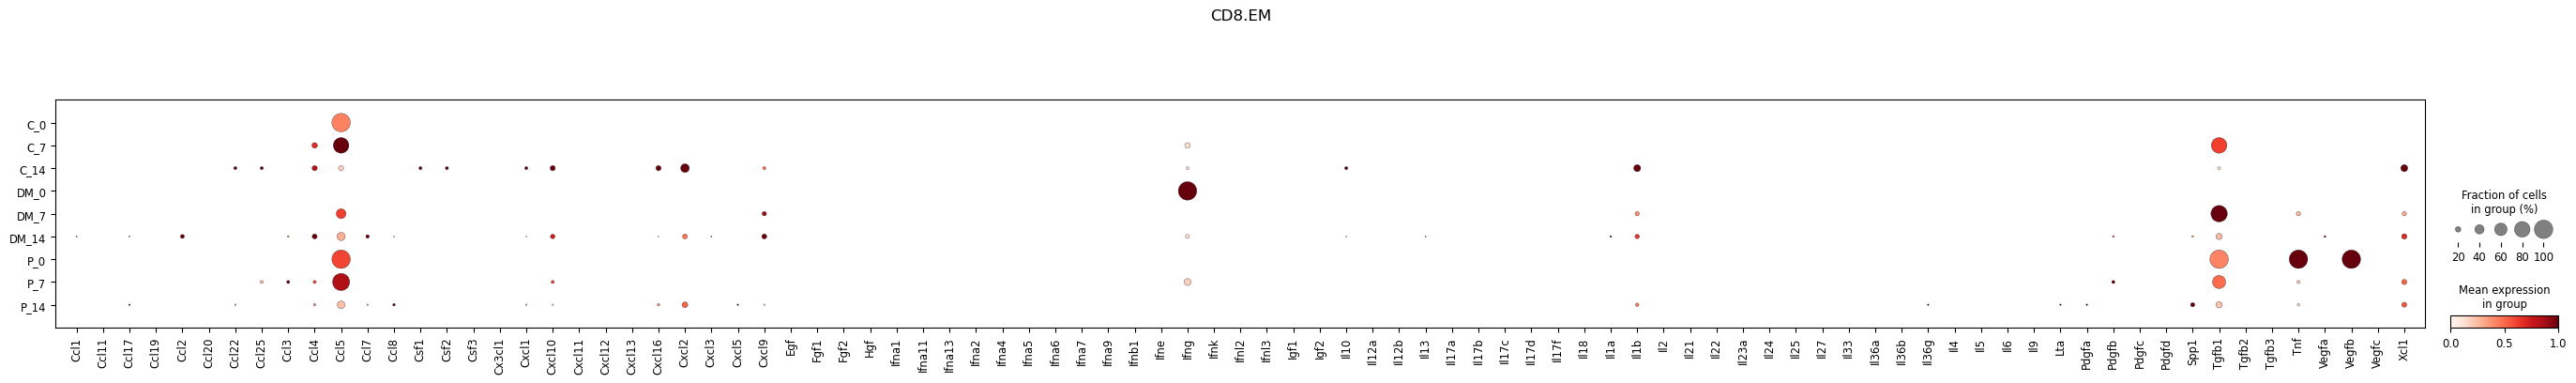

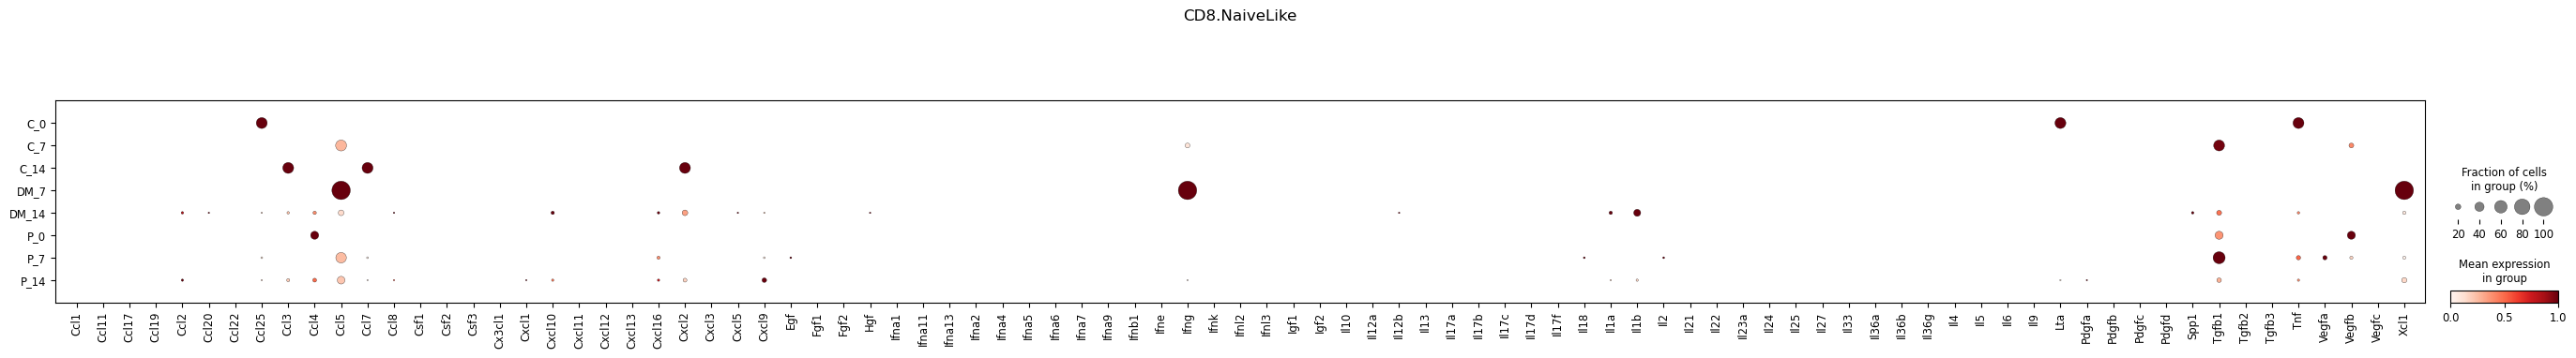

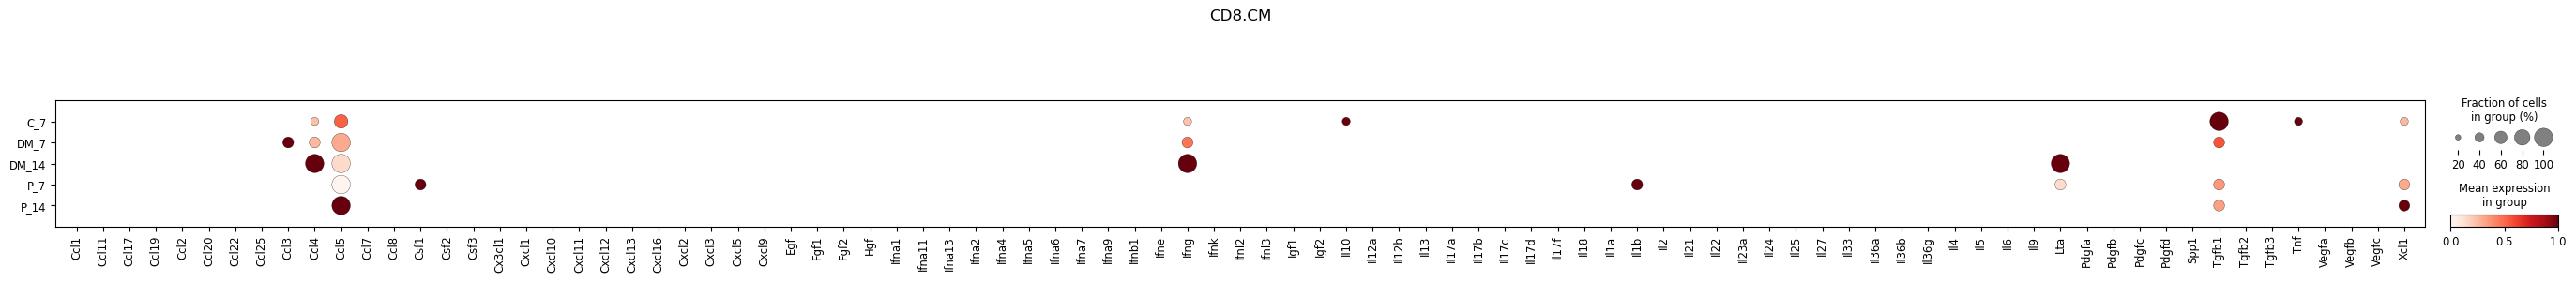

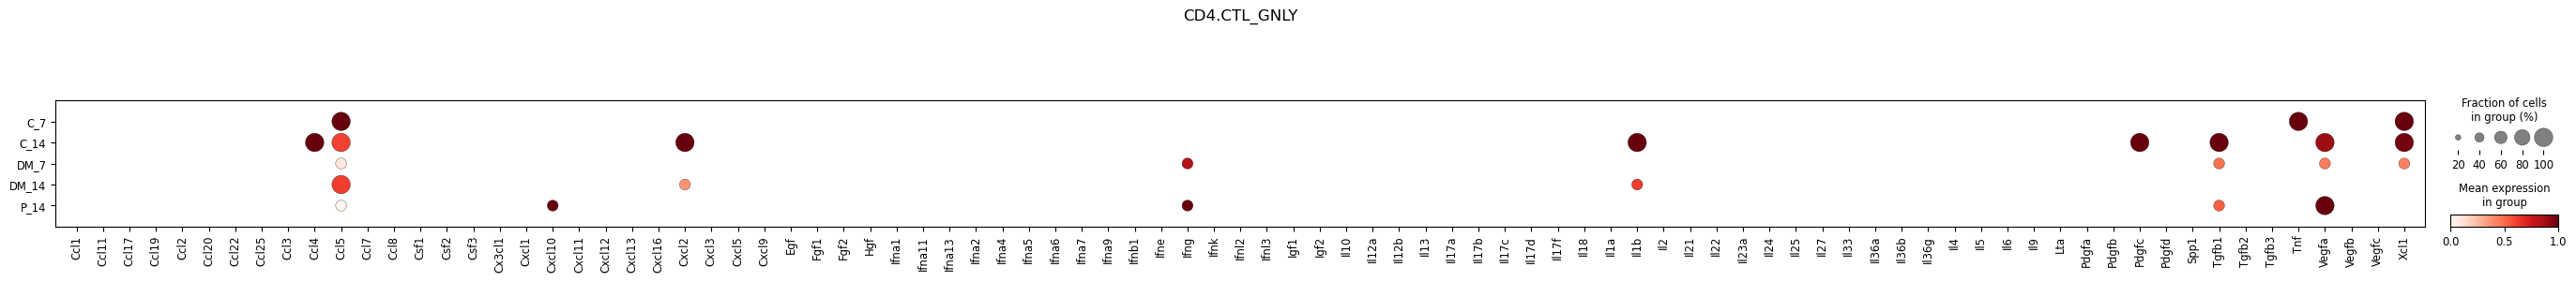

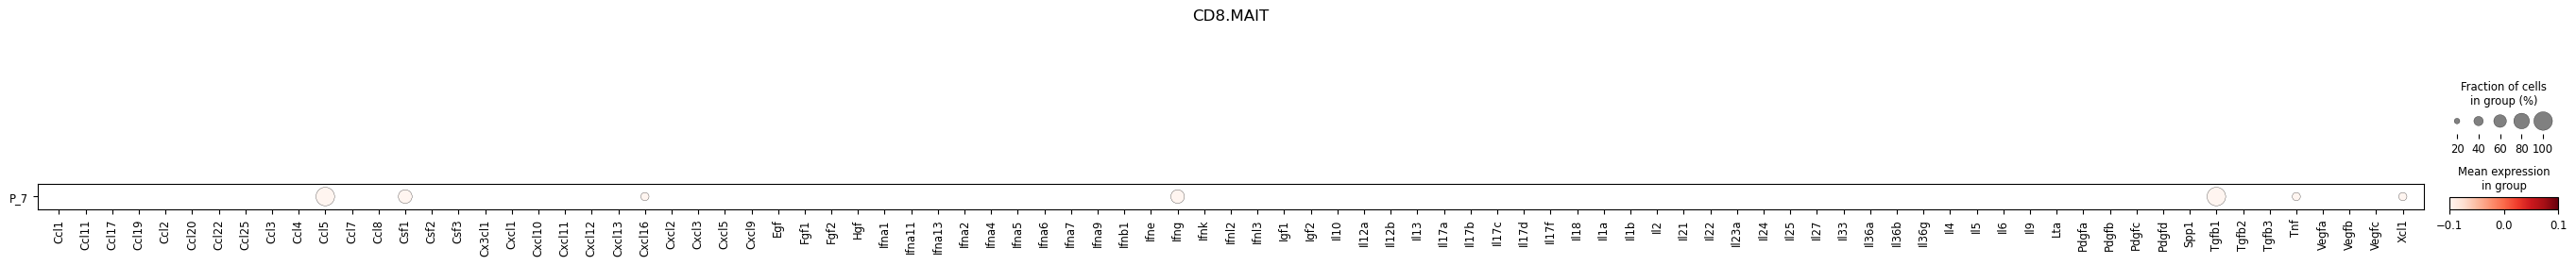

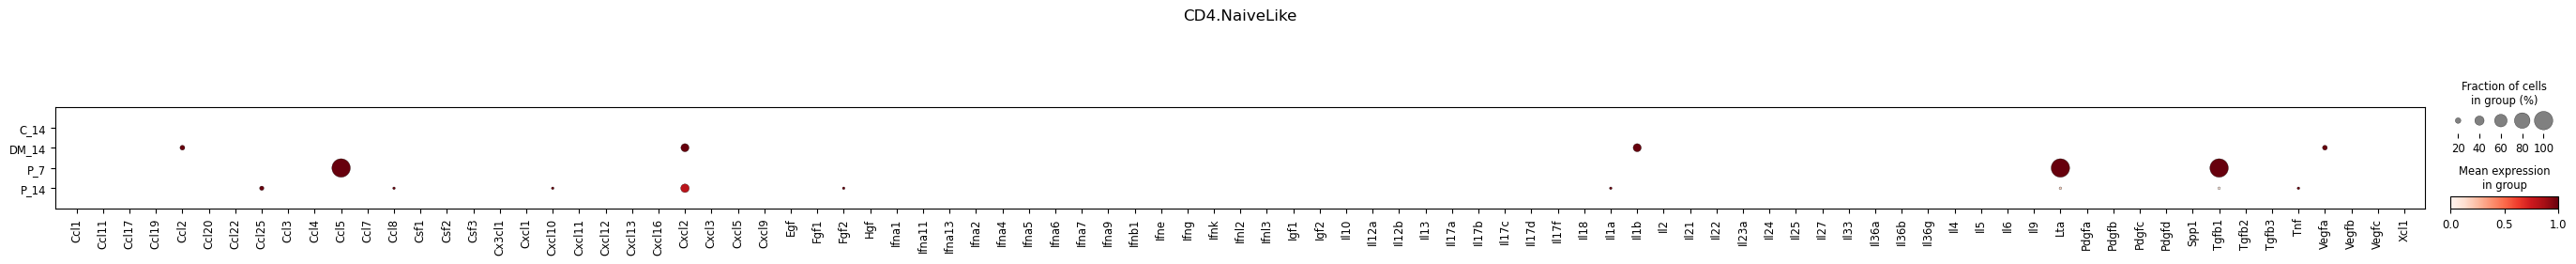

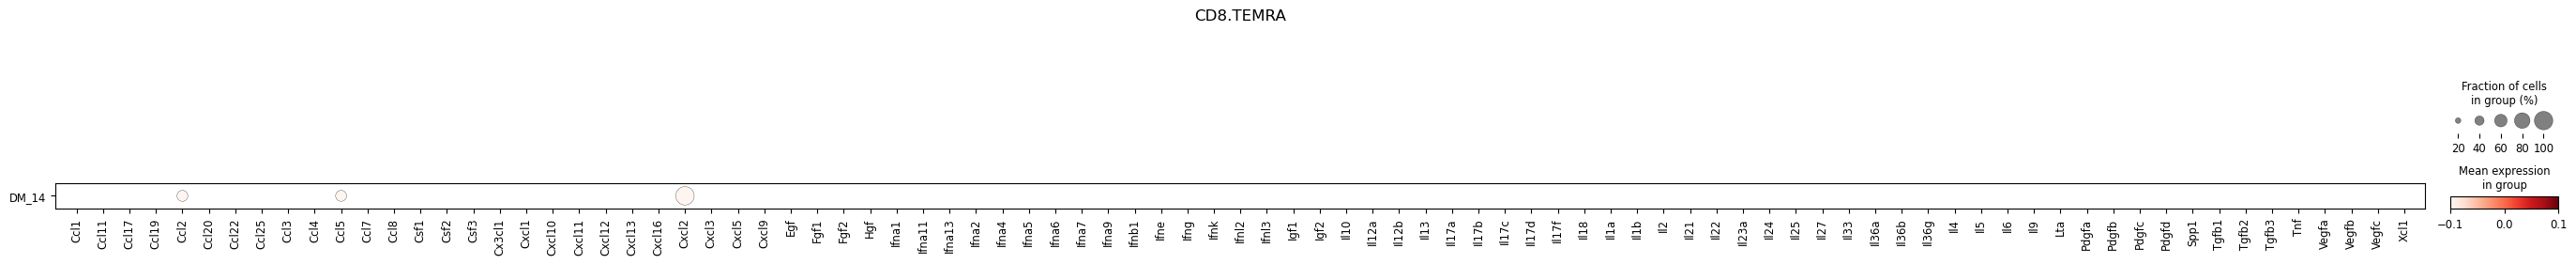

: 

: 

In [ ]:
adata_only_annotatedTC.obs.Tcell_subtype
# var = ["Il2", "Ifng", "Tnf", "Il4", "Il10", "Il17a"]
# var = cytokines['Pro_Inflammatory']
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    cytokines_in_adata = np.unique([gene for gene in cytokine_genes if gene in adata.var_names])
    sc.pl.dotplot(adata, cytokines_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

# for chemokine receptors

In [10]:
# Comprehensive list of chemokine receptors as gene symbols
chemokine_receptors = [
    # CC Chemokine Receptors (CCR family)
    "Ccr1", "Ccr2", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8", "Ccr9", "Ccr10", "Ccr11",

    # CXC Chemokine Receptors (CXCR family)
    "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6", "Cxcr7",

    # Atypical Chemokine Receptors (ACKR family, formerly decoy/scavenger receptors)
    "Ackr1", "Ackr2", "Ackr3", "Ackr4",

    # CX3C Chemokine Receptor
    "Cx3cr1",

    # XC Chemokine Receptor
    "Xcr1"
]


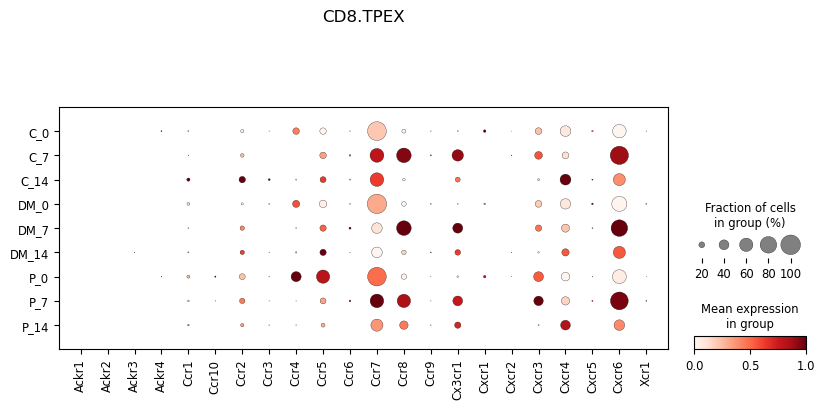

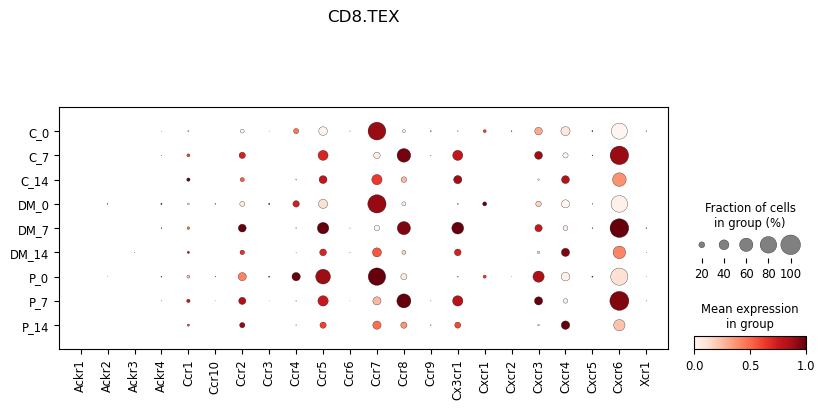

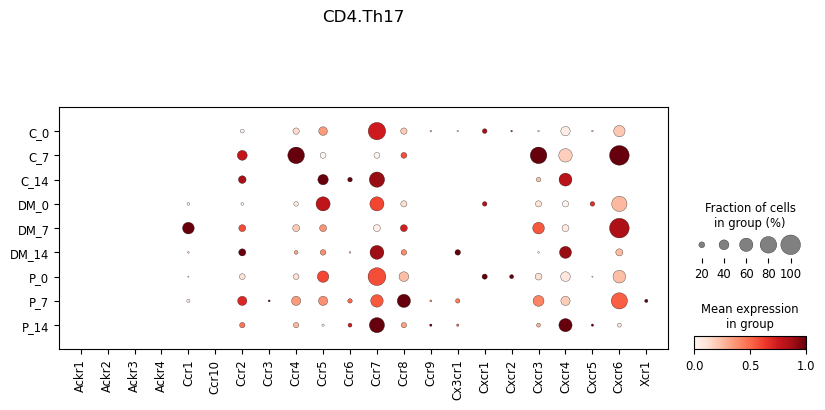

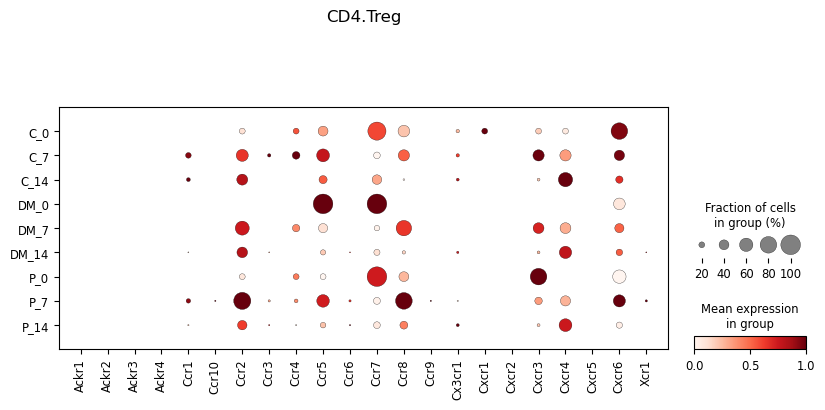

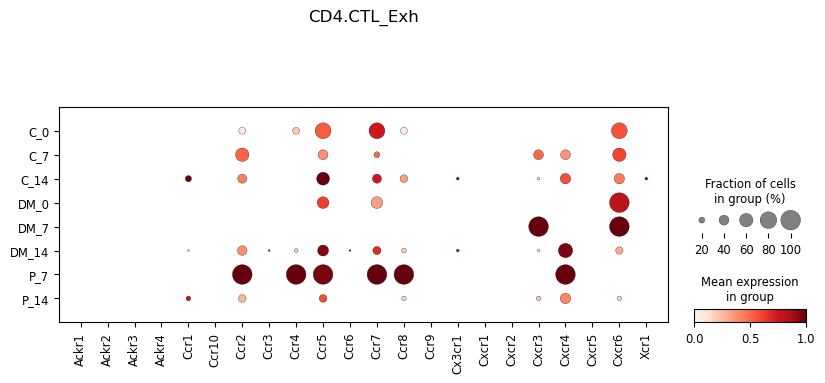

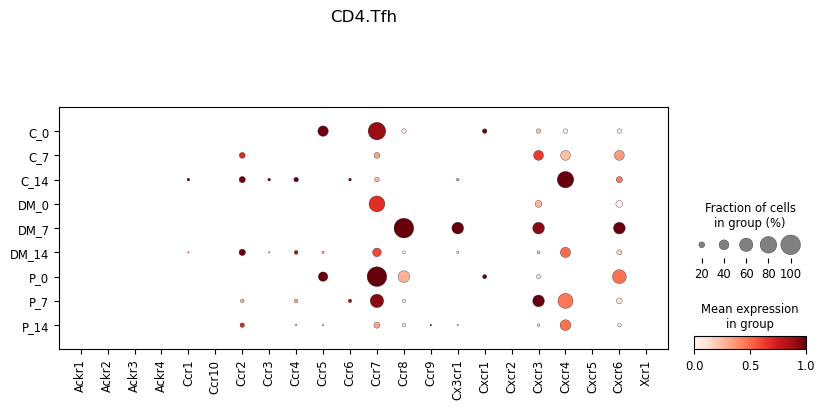

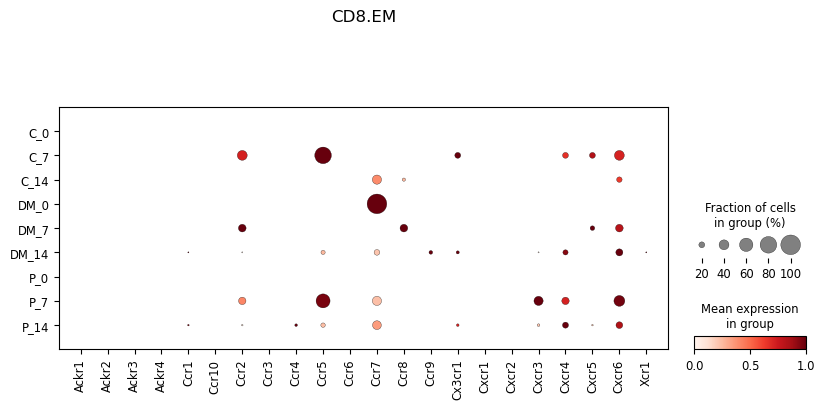

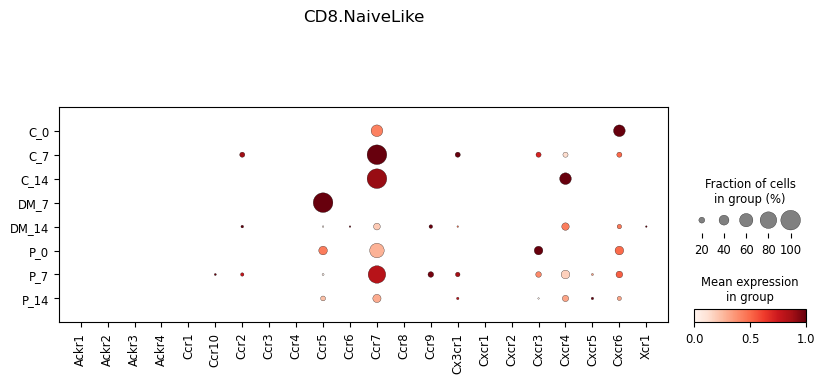

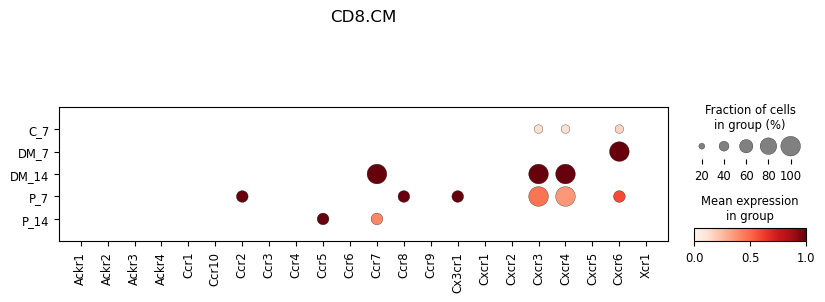

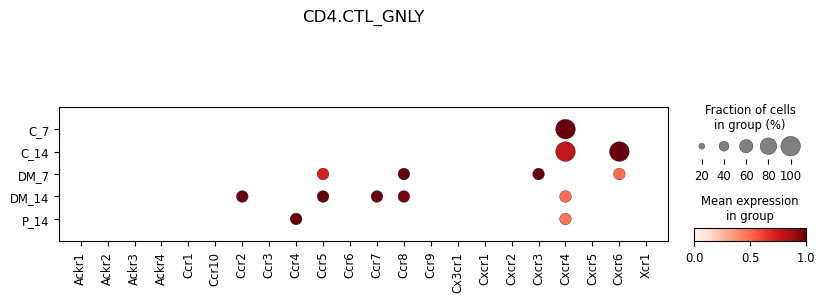

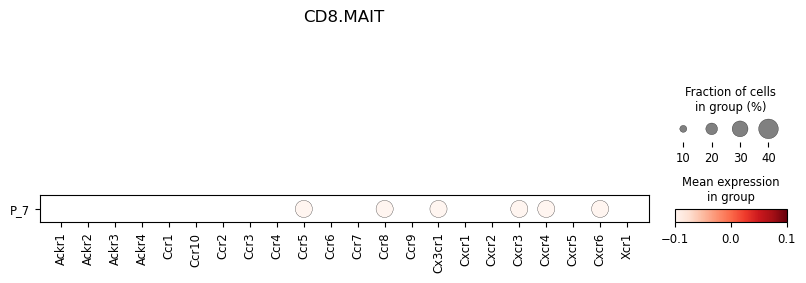

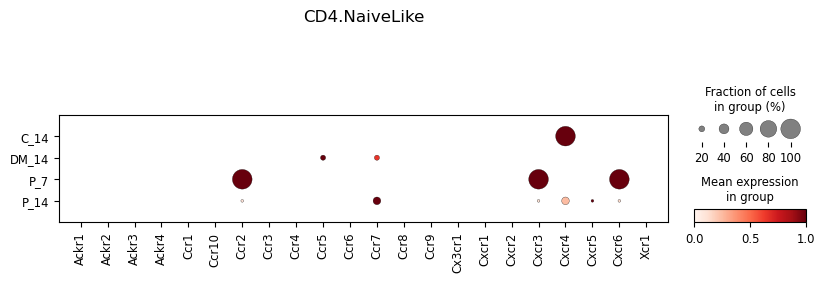

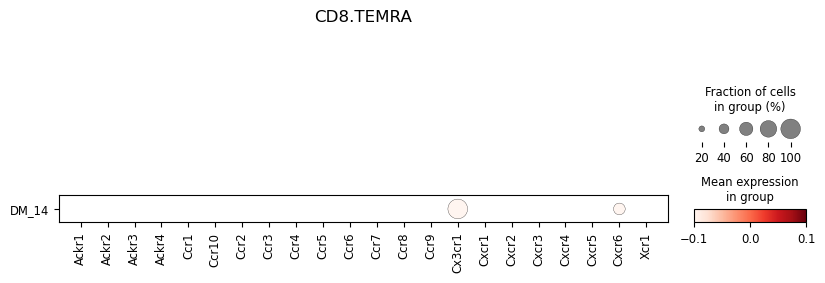

: 

: 

In [ ]:
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    chemokine_receptors_in_adata = np.unique([gene for gene in chemokine_receptors if gene in adata.var_names])
    sc.pl.dotplot(adata, chemokine_receptors_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

maiks recommendations to search for

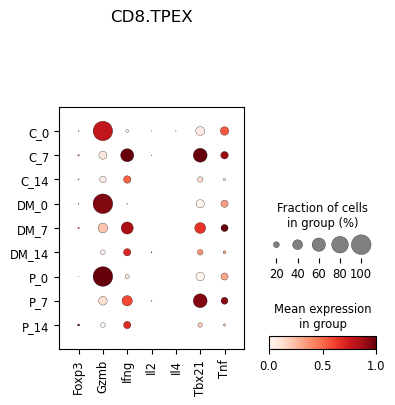

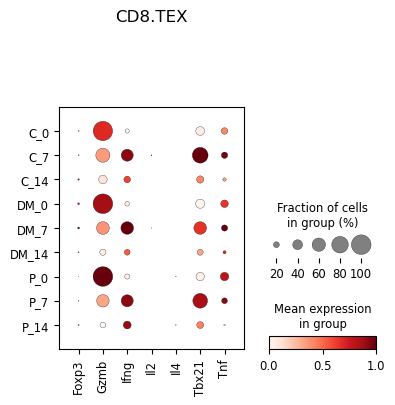

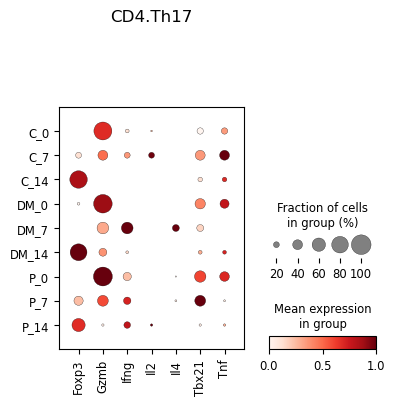

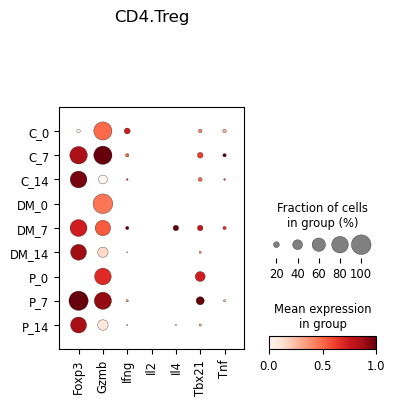

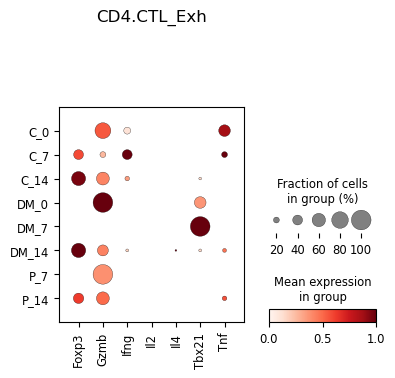

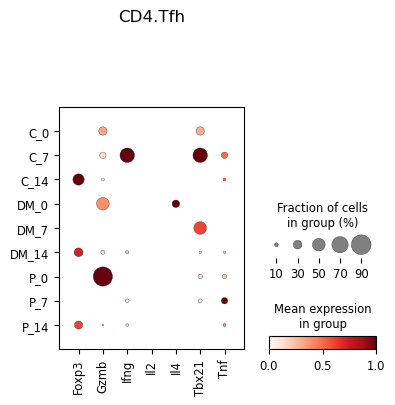

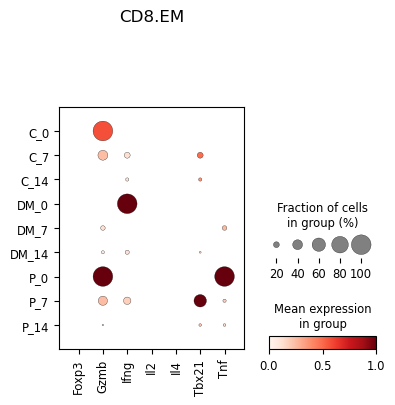

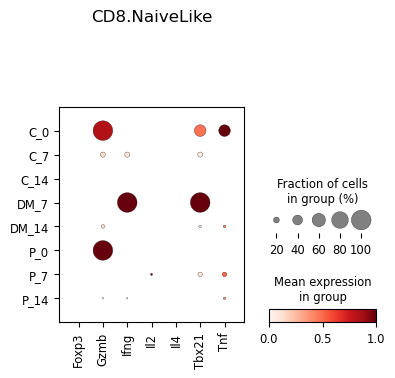

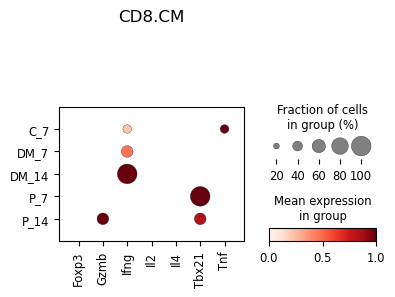

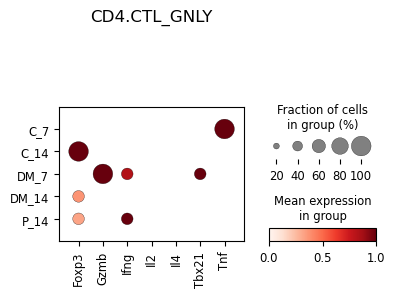

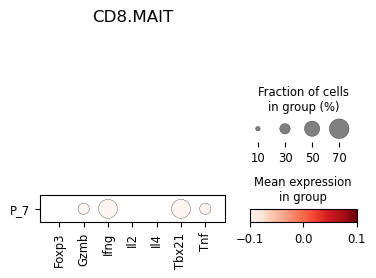

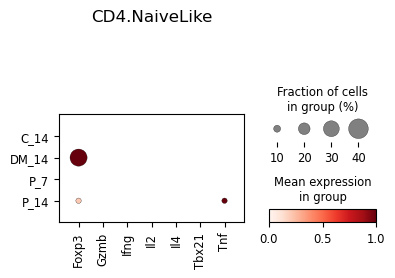

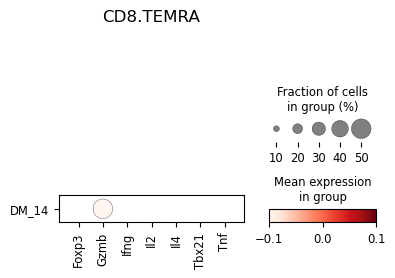

: 

: 

In [ ]:
interesting_genes = ["Tnf", "Ifng", "Il2", "Gzmb", "Tbx21", "Foxp3", "Il4"]
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    interesting_genes_in_adata = np.unique([gene for gene in interesting_genes if gene in adata.var_names])
    sc.pl.dotplot(adata, interesting_genes_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

### transcriptionfacotors

In [11]:
mouse_tcell_transcription_factors = [
    "Tcf7",         # Key for T-cell development (important for naïve T cells and differentiation)
    "Gata3",        # Important for Th2 differentiation
    "Tbx21",        # Critical for Th1 differentiation (mouse ortholog of T-bet)
    "Rorc",         # Master regulator for Th17 differentiation
    "Foxp3",        # Essential for Treg development
    "Eomes",         # Important for CD8+ T cell development and function
    "Runx3",        # Important for CD8+ T cell differentiation
    "Notch1",       # Key for early T-cell development and lineage commitment
    "Bcl11b",       # Essential for T-cell commitment and differentiation
    "Id2",          # Involved in early T-cell progenitor development
    "Zeb2",         # Involved in T-cell lineage commitment
    "Blimp1",       # Important for differentiation of effector T-cells, including CD8+ cytotoxic T-cells
    "Tcf1",         # Important for T-cell memory development
    "Nfatc1",       # Key for T-cell activation and differentiation
    "Ap-1",         # Affects T-cell activation and cytokine production
    "Stat5",        # Important for T-cell survival, proliferation, and differentiation
    "Stat3",        # Critical for Th17 differentiation and immune responses
    "Nfil3",        # Regulator of innate lymphoid cell (ILC) development, and impacts CD8+ T cells
    "Batf",         # Involved in Th17 differentiation and function
    "Myc",          # Regulates T-cell metabolism and effector function
    "Klf2",         # Important for T-cell homeostasis and function
    "Hif1a",        # Regulates metabolic adaptation in T-cells, especially in CAR T-cells
    "Tcf4",         # Regulates memory T-cell differentiation
    "Cebpb",        # Regulates immune response, including in CD8+ T cells
    "Gfi1",         # Regulates differentiation and effector function of T-cells
    "Irf4",         # Involved in T-helper differentiation and effector function
    "Ikzf3",        # Controls differentiation and function of CD4+ T-cells and Tregs
    "Maf",          # Important for Th17 and other T-helper subsets
    "Klf4",         # Plays a role in T-cell differentiation and immune responses
    "Tbx21",        # Key regulator of Th1 differentiation (mouse ortholog of T-bet)
    "Ctla4",        # Regulator of T-cell activation (important for T-cell exhaustion)
    "Pdcd1",        # Marker for T-cell exhaustion, also plays a role in CAR T-cell function (mouse ortholog of PD-1)
]

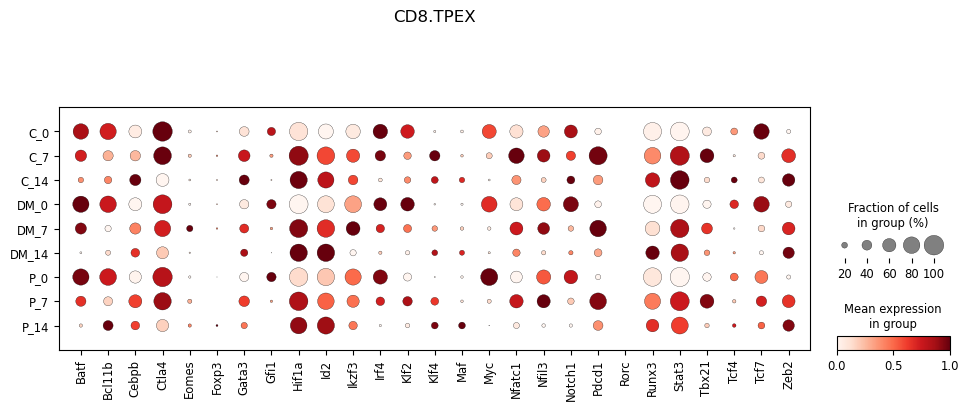

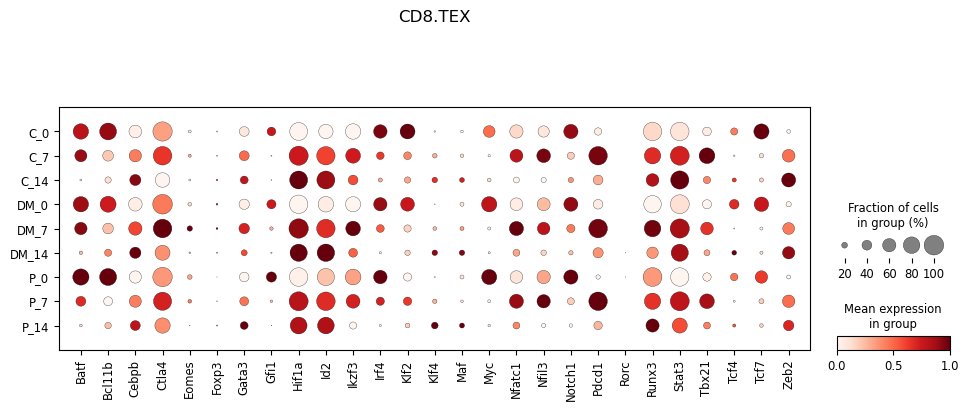

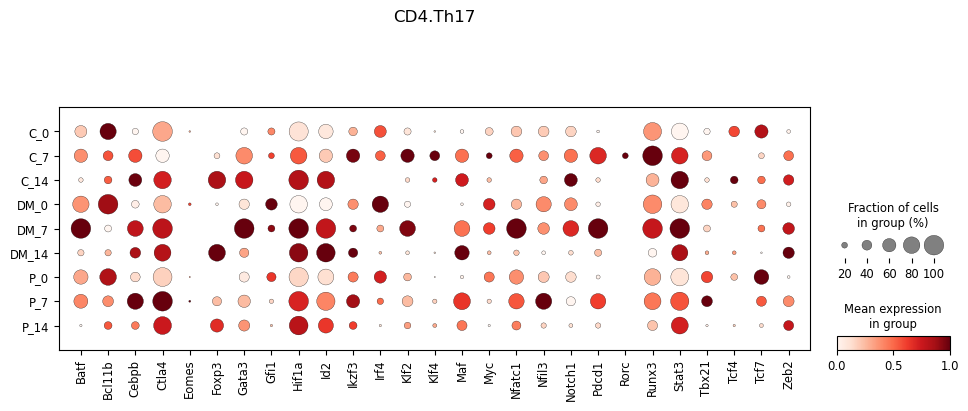

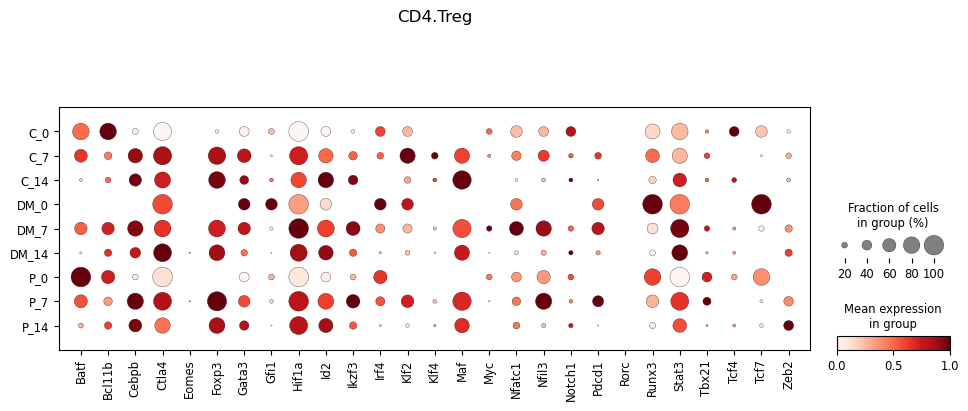

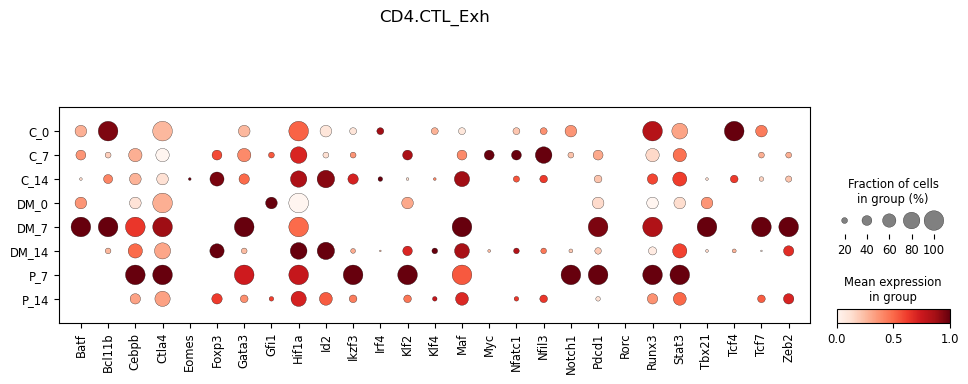

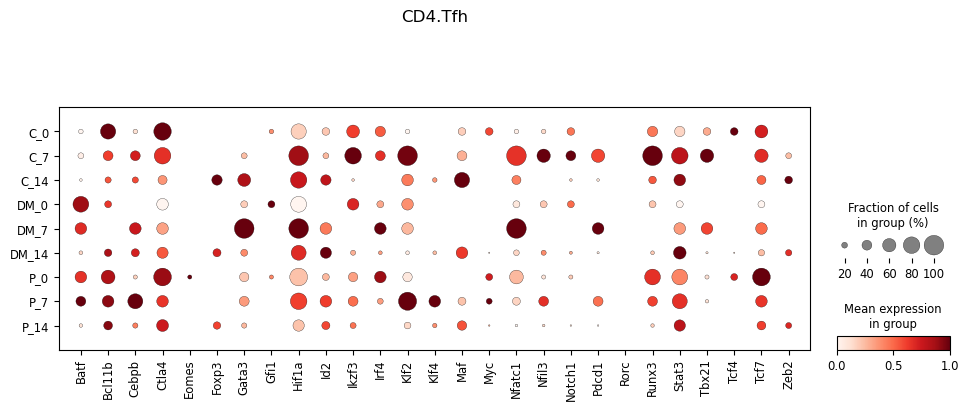

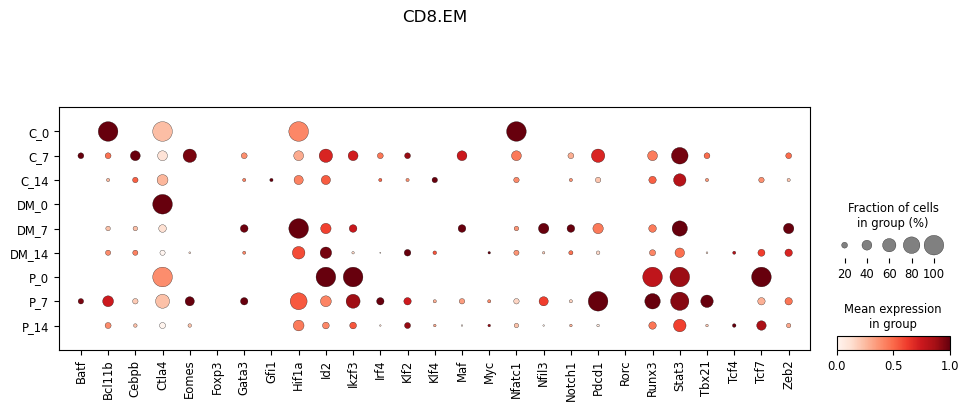

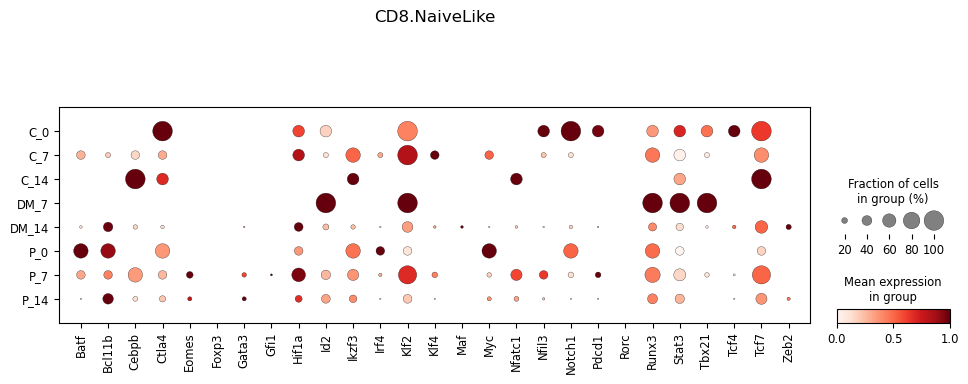

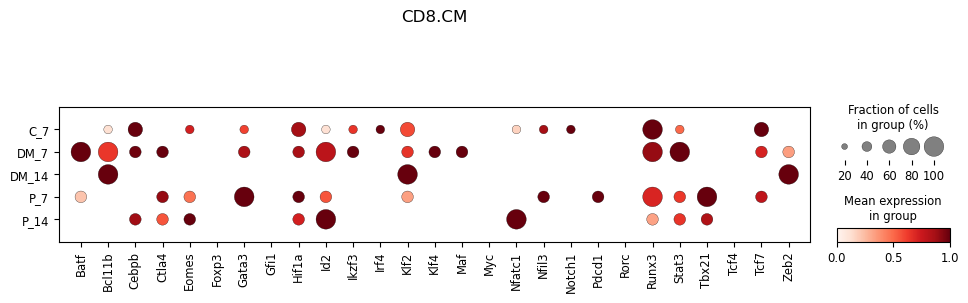

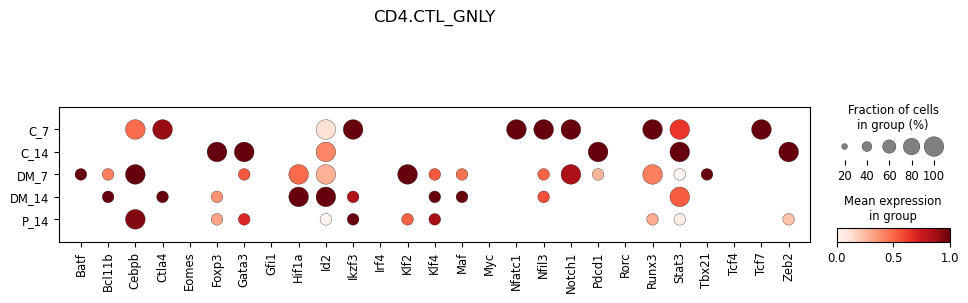

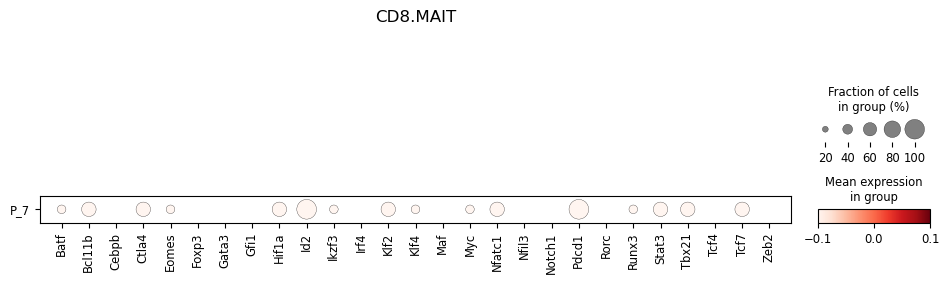

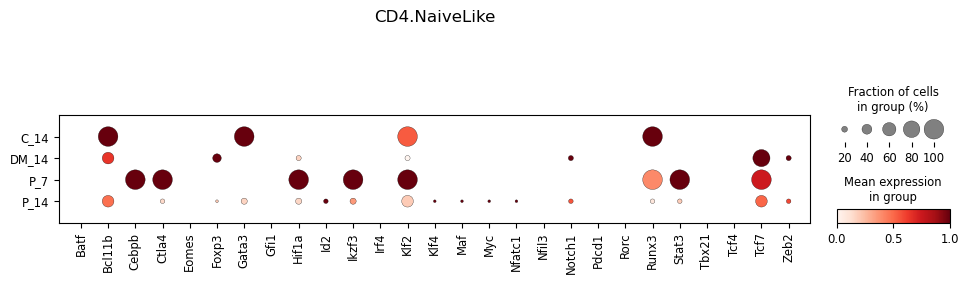

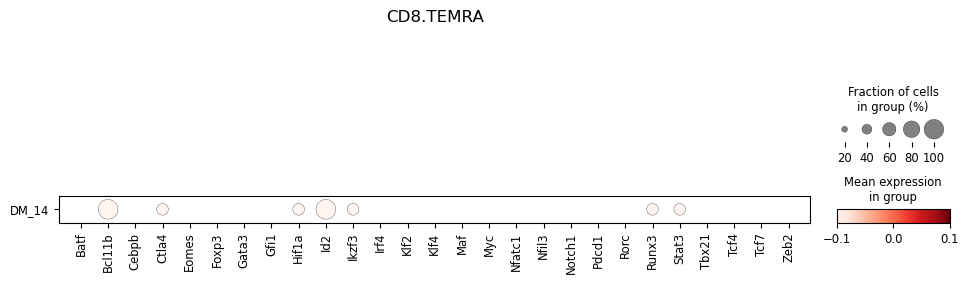

: 

: 

In [ ]:
adata_only_annotatedTC.obs.Tcell_subtype
subtypes = adata_only_annotatedTC.obs.Tcell_subtype.unique()

for subtype in subtypes:
    adata = adata_only_annotatedTC[adata_only_annotatedTC.obs.Tcell_subtype == subtype].copy()
    tfs_in_adata = np.unique([gene for gene in mouse_tcell_transcription_factors if gene in adata.var_names])
    sc.pl.dotplot(adata, tfs_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", title=subtype)

# try pseudobulk analysis

## for TCells overall

### import data with all cellsubtypes annotated

In [12]:
adata_all_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/ImmunoCC_annotated/all_celltypes_annotated.h5ad') 
#check if adata object has raw counts, if not import raw counts for deseq
adata_all_annotated.X.max()
#add the replicates for statistical purposes
oa.extract_replicate(adata_all_annotated, 'Classification')

### compute the deseq statistics as a table, store for all comparisons in a dict and plot as volcanoplot

In [13]:
#create a subset of the adata object for better overview
diff_adata = adata_all_annotated.copy()
diff_adata.obs = diff_adata.obs[['day', 'condition', 'replicate', 'parent_immune_type', 'cellsubtypesAll']]
#aggregate to pseudobulks for pydeseq2 anlysis
pb = dplt.aggregate_and_sum(diff_adata, 'parent_immune_type', 'Tcell')

In [33]:
#create contrast dictionary for contrast to analyse (here P vs C and P vs DM)
contrast_dict = {'d0:PvsC' : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0]), 
                 'd7:PvsC' : np.array([0, 0, 1, 0, 0, 0, 0, 0, 1]),
                 'd14:PvsC' : np.array([0, 0, 1, 0, 0, 0, 1, 0, 0]),
                 'd0:PvsDM' : np.array([0, -1, 1, 0, 0, 0, 0, 0, 0]),
                 'd7:PvsDM' : np.array([0, -1, 1, 0, 0, 0, 0, -1, 1]),
                 'd14:PvsDM' : np.array([0, -1, 1, 0, 0, -1, 1, 0, 0])}
#create a dict storing all contrasts for later use
tcell_de_stats = dplt.compute_statistics(pb, contrast_dict)

Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.72 seconds.

Fitting dispersion trend curve...
... done in 1.66 seconds.

Fitting MAP dispersions...
... done in 4.39 seconds.

Fitting LFCs...
... done in 4.53 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.22 seconds.

Running Wald tests...
... done in 4.48 seconds.

Running Wald tests...
... done in 4.24 seconds.

Running Wald tests...
... done in 4.47 seconds.

Running Wald tests...
... done in 4.14 seconds.

Running Wald tests...
... done in 4.51 seconds.



In [14]:
### save
file = './01_data/processed/merged_and_processed/pyDeseq2_res/tcell_stats.pkl'
# with open(file, 'wb') as f:
#     pickle.dump(tcell_de_stats, f)

###load
with open(file, "rb") as f:
    tcell_de_stats = pickle.load(f)

In [15]:
color_dict = {'TFs' :mouse_tcell_transcription_factors, 'Cytokines': cytokine_genes, 'Chemokine Receptors': chemokine_receptors}
labels = [val for sublist in color_dict.values() for val in sublist]

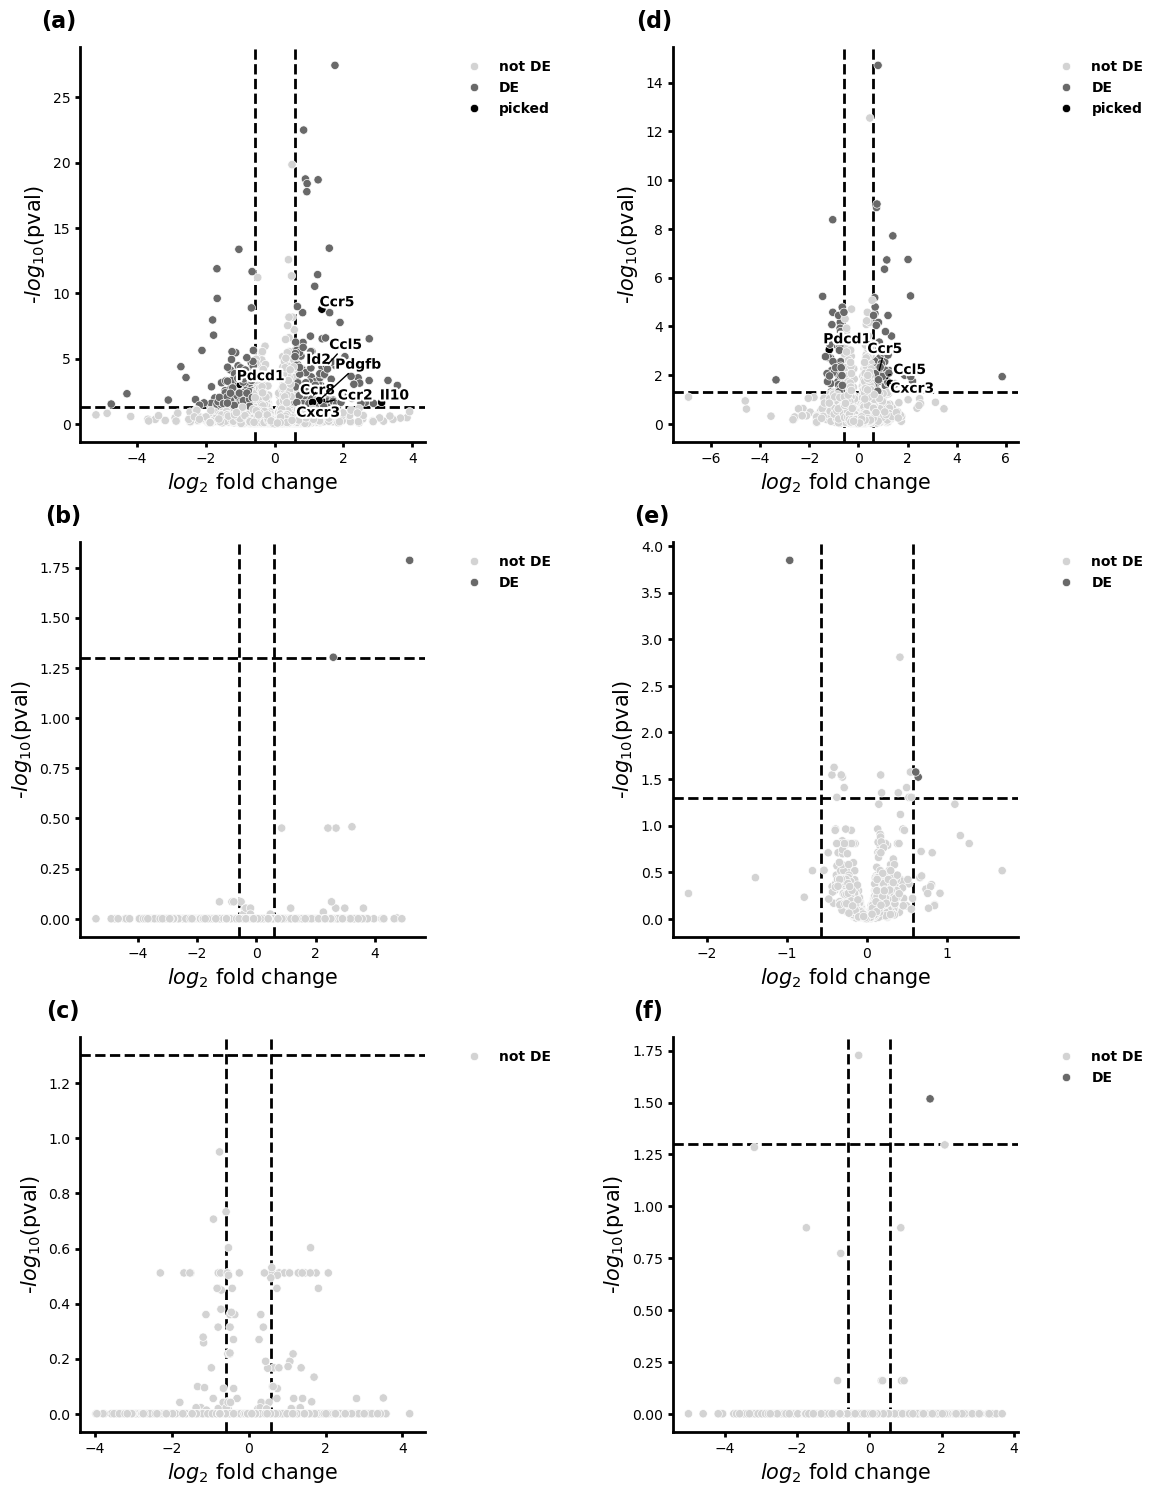

In [18]:
importlib.reload(dplt)
ax_switch = {0: 0, 1: 2, 2: 4, 3: 1, 4: 3, 5: 5}
subplot_labels = list(string.ascii_lowercase[:6]) 
# Create subplots (3 columns, 2 rows)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()  # Flatten for easier iteration
# Loop through datasets and plot each in a subplot
for i, key in enumerate(list(tcell_de_stats.keys())[:6]): 
    tcell_de_stats[key] = dplt.volcano(tcell_de_stats[key], symbol='index', log2fc_thresh=0.58, ax=axes[ax_switch[i]], to_label=labels)  # Pass ax
    # Add subplot label in top-left corner of each plot
    x_min, _ = axes[ax_switch[i]].get_xlim()  # Get x-axis limits
    y_max = axes[ax_switch[i]].get_ylim()[1]  # Get top y-axis limit
    axes[ax_switch[i]].text(x_min * 1.2, y_max * 1.1,  # Adjust position dynamically
                     f"({subplot_labels[i]})", fontsize=16, fontweight='bold',
                     ha="left", va="top")
# Adjust layout to prevent overlap
plt.tight_layout()
path = './03_results/figures/diffex/deseq_tcs.png'
plt.savefig(path, bbox_inches='tight', dpi=300)
plt.show()

## For all other parent subtypes

In [16]:
diff_adata_nona = diff_adata[~diff_adata.obs['parent_immune_type'].isna()].copy()
#create dict of all cellsubtypes with pseudobulks
pb_subtypes = {celltype: dplt.aggregate_and_sum(diff_adata, 'parent_immune_type', celltype) 
                    for celltype in diff_adata_nona.obs['parent_immune_type'].unique()}

In [17]:
select = ['NK', 'Macrophage', 'Monocyte', 'DC']
#select only those that can be tested, remove potential d0 samples, as they are not interesting here (d0 are only CAR T cells)
pb_selected_prnt = {key: pb_subtypes.get(key)[pb_subtypes[key].obs.day != '0'] for key in select}

In [ ]:
#create contrast dictionary for contrast to analyse (here P vs C and P vs DM)
contrast_dict = {'d7:PvsC' : np.array([0, 0, 1, 0, 0, 1]),
                 'd14:PvsC' : np.array([0, 0, 1, 0, 0, 0]),
                 'd7:PvsDM' : np.array([0, -1, 1, 0, -1, 1]),
                 'd14:PvsDM' : np.array([0, -1, 1, 0, 0, 0])}
#create a dict storing all contrasts for later use
innate_stats = {key: dplt.compute_statistics(pb, contrast_dict) for key, pb in pb_selected_prnt.items()}

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.24 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 3.82 seconds.

Fitting LFCs...
... done in 4.19 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.

Running Wald tests...
... done in 3.17 seconds.

Running Wald tests...
... done in 3.06 seconds.

Running Wald tests...
... done in 3.15 seconds.

Running Wald tests...
... done in 3.36 seconds.

Running Wald tests...
... done in 3.07 seconds.

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.33 seconds.

Fitting dispersion trend curve...
... done in 1.68 seconds.

Fitting MAP dispersions...
... done in 4.12 seconds.

Fitting LFCs...
... done in 5.14 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.11 seconds.

Running Wald tests...
... done in 3.58 seconds.

Running Wald tests...
... done in 3.49 seconds.

Running Wald tests...
... done in 3.20 seconds.

Running Wald tests...
... done in 3.11 seconds.

Running Wald tests...
... done in 3.36 seconds.

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.92 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 2.69 seconds.

Fitting LFCs...
... done in 3.11 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.35 seconds.

Running Wald tests...
... done in 2.11 seconds.

Running Wald tests...
... done in 2.06 seconds.

Running Wald tests...
... done in 2.49 seconds.

Running Wald tests...
... done in 2.12 seconds.

Running Wald tests...
... done in 2.12 seconds.

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.79 seconds.

Fitting dispersion trend curve...
... done in 0.99 seconds.

Fitting MAP dispersions...
... done in 3.15 seconds.

Fitting LFCs...
... done in 3.82 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.26 seconds.

Running Wald tests...
... done in 2.38 seconds.

Running Wald tests...
... done in 2.38 seconds.

Running Wald tests...
... done in 2.58 seconds.

Running Wald tests...
... done in 2.44 seconds.

Running Wald tests...
... done in 2.33 seconds.



In [51]:
### save
file = './01_data/processed/merged_and_processed/pyDeseq2_res/innate_stats.pkl'
# with open(file, 'wb') as f:
#     pickle.dump(innate_stats, f)

###load
with open(file, "rb") as f:
    innate_stats = pickle.load(f)

### plotting

NK


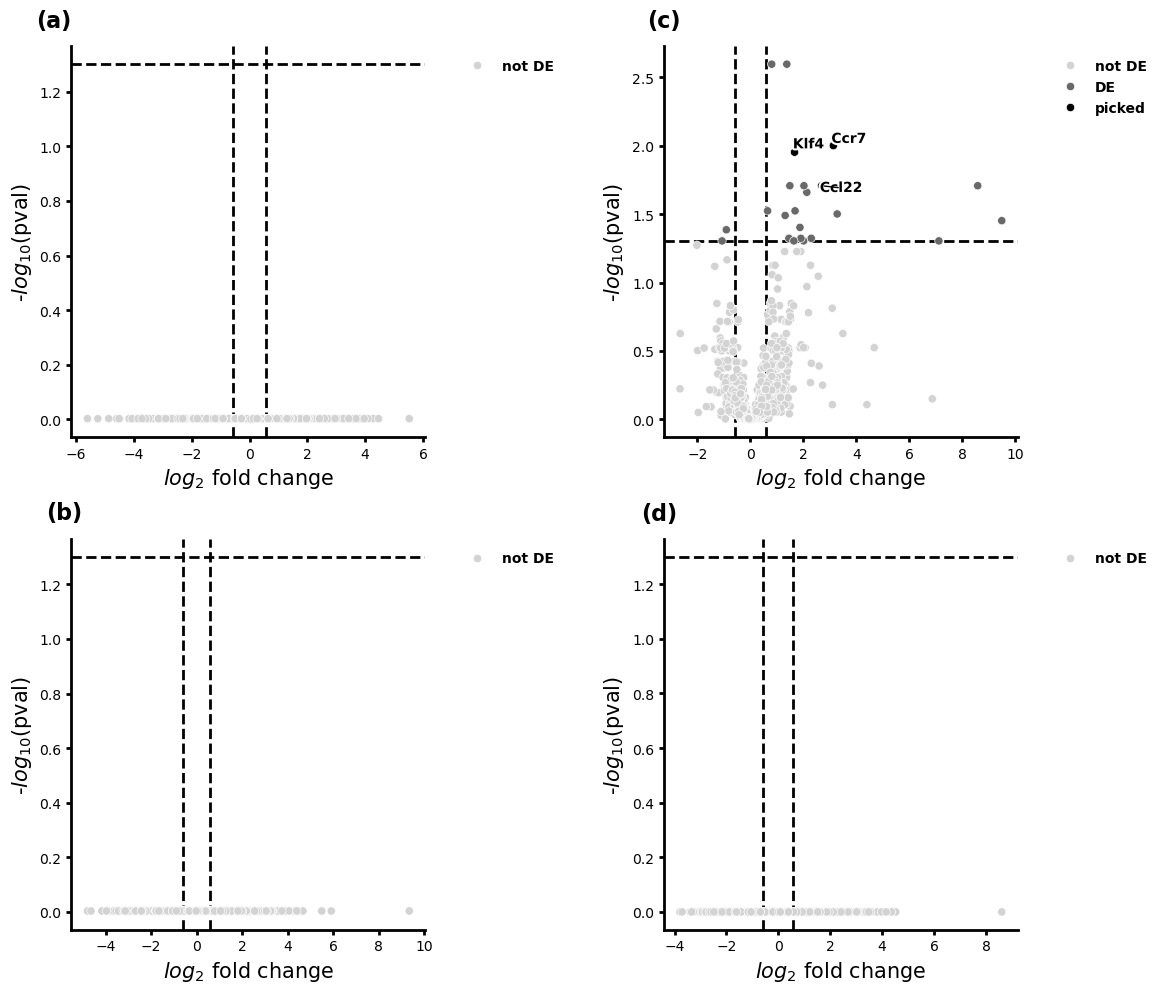

Macrophage


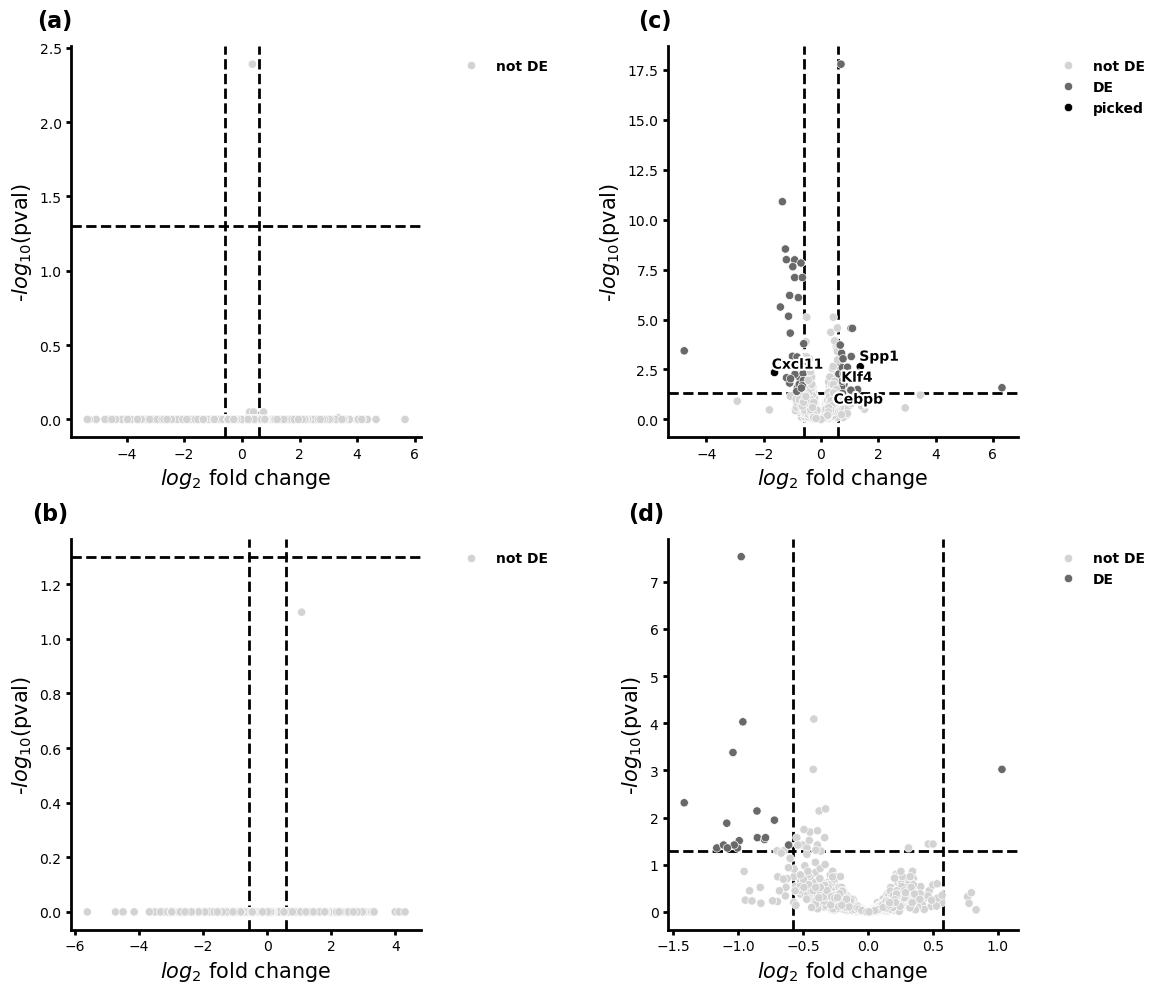

Monocyte


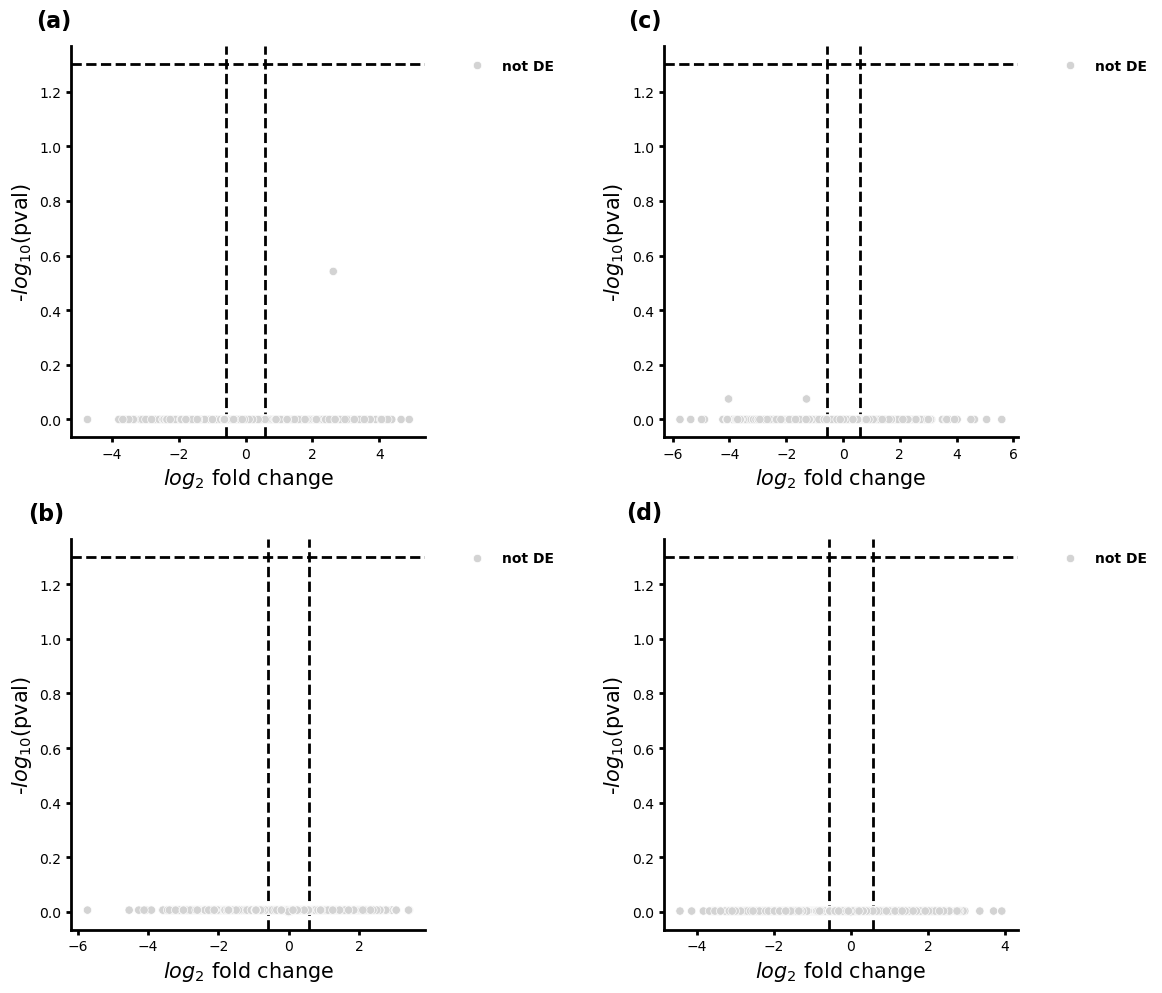

DC


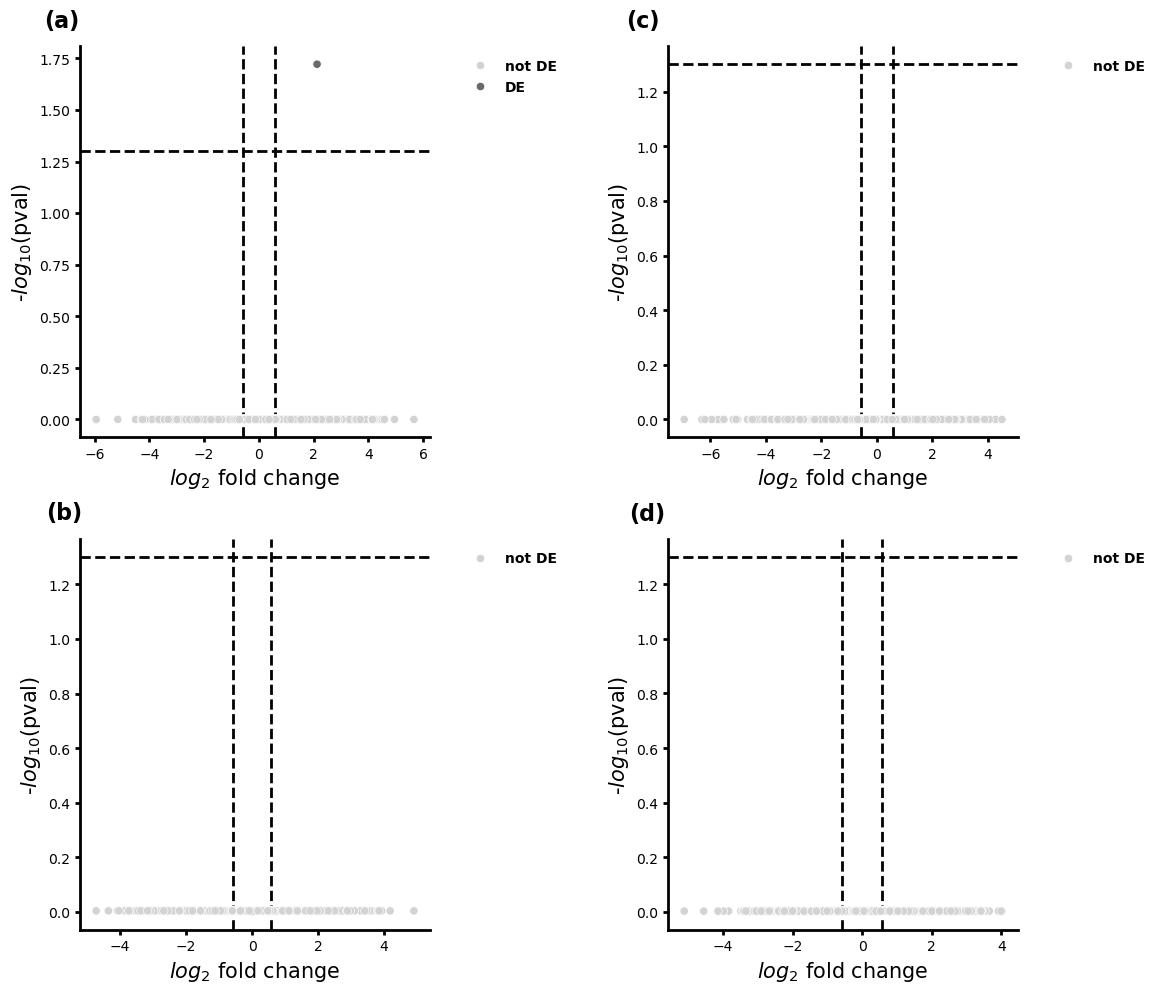

In [55]:
importlib.reload(dplt)
for celtype, typ in innate_stats.items():
    print(celtype)
    ax_switch = {0: 0, 1: 2, 2: 1, 3: 3}
    subplot_labels = list(string.ascii_lowercase[:4]) 
    # Create subplots (3 columns, 2 rows)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten for easier iteration
    # Loop through datasets and plot each in a subplot
    for i, key in enumerate(list(typ.keys())): 
        dplt.volcano(typ[key], symbol='index', log2fc_thresh=0.58, ax=axes[ax_switch[i]], to_label=labels)  # Pass ax
        # Add subplot label in top-left corner of each plot
        x_min, _ = axes[ax_switch[i]].get_xlim()  # Get x-axis limits
        y_max = axes[ax_switch[i]].get_ylim()[1]  # Get top y-axis limit
        axes[ax_switch[i]].text(x_min * 1.2, y_max * 1.1,  # Adjust position dynamically
                         f"({subplot_labels[i]})", fontsize=16, fontweight='bold',
                         ha="left", va="top")
        # axes[i].text(1,1, f'{key}')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

## for Cell subtypes

In [19]:
#create a subset of the adata object for better overview
#eliminate na
diff_adata_nona = diff_adata[~diff_adata.obs['cellsubtypesAll'].isna()].copy()
#create dict of all cellsubtypes with pseudobulks
pb_subtypes = {celltype: dplt.aggregate_and_sum(diff_adata, 'cellsubtypesAll', celltype) 
                    for celltype in diff_adata_nona.obs['cellsubtypesAll'].unique()}

In [20]:
select = ['CD8.TPEX','CD8.TEX','CD4.Th17','CD4.Treg','CD4.CTL_Exh','CD4.Tfh','CD8.EM','CD8.NaiveLike','CD8.CM','CD4.CTL_GNLY','CD8.MAIT','CD4.NaiveLike','CD8.TEMRA']
tc_sub = diff_adata_nona[diff_adata_nona.obs.cellsubtypesAll.isin(select)].copy()
tc_sub = tc_sub[tc_sub.obs.day == '0']
# sc.pp.normalize_total(tc_sub, target_sum=1e4)
# sc.pp.log1p(tc_sub)

In [21]:
#extract genes that are interesting DEs from tcell statistics
genes_picked = [val[val.color.isin(['picked'])]['index'] for key,val in tcell_de_stats.items()]
genes_DE = [val[val.color.isin(['DE'])]['index'] for key,val in tcell_de_stats.items()]

genes_picked_all = pd.concat(genes_picked, ignore_index=True).drop_duplicates().tolist()
genes_DE_all = pd.concat(genes_DE, ignore_index=True).drop_duplicates().tolist()

In [22]:
genes_DE_Xd0 = [val[val.color.isin(['DE'])]['index'] for key,val in tcell_de_stats.items() if not 'd0' in key]


In [23]:
genes_DE_Xd0 = pd.concat(genes_DE_Xd0, ignore_index=True).drop_duplicates().tolist()
genes_DE_Xd0

['Igkc', 'H2-Eb1', '5730419F03Rik', 'Ssh2', 'Ldlrad4', 'Anks1b']

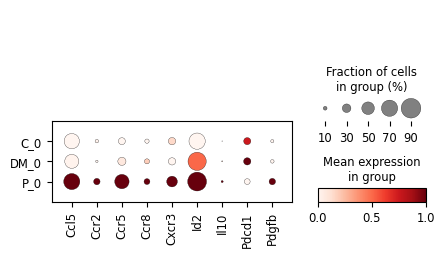

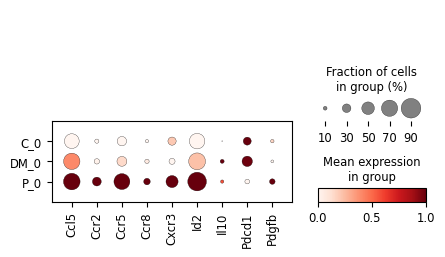

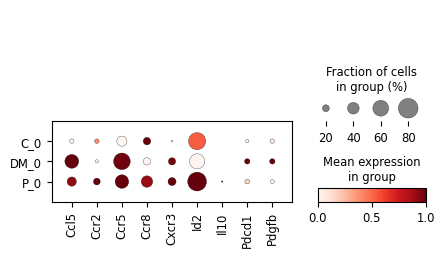

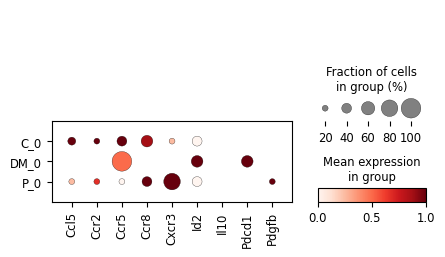

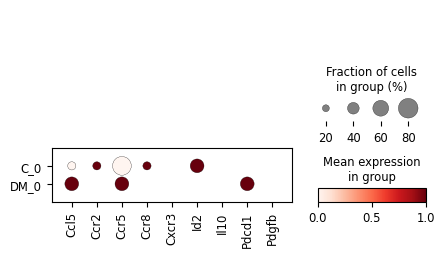

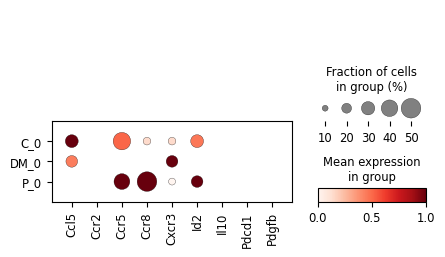

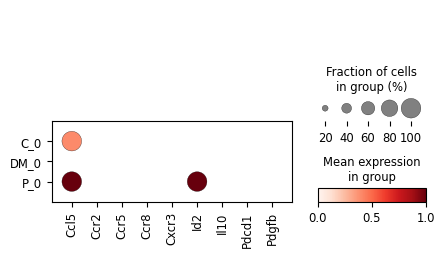

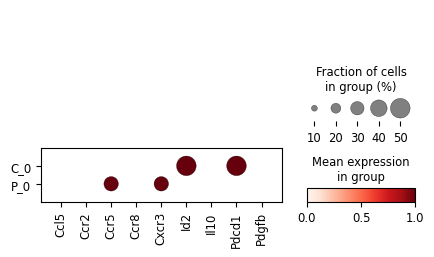

In [48]:
subtypes = tc_sub.obs.cellsubtypesAll.unique()
path = path = './03_results/figures/diffex/'
for subtype in subtypes:
    adata = tc_sub[tc_sub.obs.cellsubtypesAll == subtype].copy()
    tfs_in_adata = np.unique([gene for gene in genes_picked_all if gene in adata.var_names])
    rnmd_subtype = subtype.replace('.', '_')
    file_path = os.path.join(path, f'dotplt_{rnmd_subtype}.png')
    plot = sc.pl.dotplot(adata, tfs_in_adata, groupby=["condition", "day"], standard_scale="var", swap_axes=False, cmap="Reds", return_fig=True) #, title=subtype
    plot.savefig(file_path, bbox_inches='tight', dpi=300)
    # plt.close(plot)

In [45]:
select = ['CD8.TPEX', 'CD8.TEX', 'CD4.Th17', 'CD4.Treg', 'CD4.Tfh', 'CD8.EM']
#select only those that can be tested, remove potential d0 samples, as they are not interesting here (d0 are only CAR T cells)
pb_selected_sub = {key: pb_subtypes.get(key) for key in select}

In [ ]:
#just to check if all have same desing matrices which is important for the contrasts
def tesiting_func(pb):
    counts = pd.DataFrame(pb.X, columns = pb.var_names)
    dds = DeseqDataSet(counts=counts, metadata=pb.obs, design= '~condition * day') #includes interaction terms
    return dds
test = {key: tesiting_func(pb) for key, pb in pb_selected_sub.items()}
# test['CD4.CTL_Exh']._check_full_rank_design()
for key,val in test.items():
    print(f'celltype: {key}')
    print(val.obsm['design_matrix'].columns)
    # print(val._check_full_rank_design())

celltype: CD8.TPEX
Index(['Intercept', 'condition[T.DM]', 'condition[T.P]', 'day[T.14]',
       'day[T.7]', 'condition[T.DM]:day[T.14]', 'condition[T.P]:day[T.14]',
       'condition[T.DM]:day[T.7]', 'condition[T.P]:day[T.7]'],
      dtype='object')
celltype: CD8.TEX
Index(['Intercept', 'condition[T.DM]', 'condition[T.P]', 'day[T.14]',
       'day[T.7]', 'condition[T.DM]:day[T.14]', 'condition[T.P]:day[T.14]',
       'condition[T.DM]:day[T.7]', 'condition[T.P]:day[T.7]'],
      dtype='object')
celltype: CD4.Th17
Index(['Intercept', 'condition[T.DM]', 'condition[T.P]', 'day[T.14]',
       'day[T.7]', 'condition[T.DM]:day[T.14]', 'condition[T.P]:day[T.14]',
       'condition[T.DM]:day[T.7]', 'condition[T.P]:day[T.7]'],
      dtype='object')
celltype: CD4.Treg
Index(['Intercept', 'condition[T.DM]', 'condition[T.P]', 'day[T.14]',
       'day[T.7]', 'condition[T.DM]:day[T.14]', 'condition[T.P]:day[T.14]',
       'condition[T.DM]:day[T.7]', 'condition[T.P]:day[T.7]'],
      dtype='object')
c

In [48]:
#create contrast dictionary for contrast to analyse (here P vs C and P vs DM)
contrast_dict = {'d0:PvsC' : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0]), 
                 'd7:PvsC' : np.array([0, 0, 1, 0, 0, 0, 0, 0, 1]),
                 'd14:PvsC' : np.array([0, 0, 1, 0, 0, 0, 1, 0, 0]),
                 'd0:PvsDM' : np.array([0, -1, 1, 0, 0, 0, 0, 0, 0]),
                 'd7:PvsDM' : np.array([0, -1, 1, 0, 0, 0, 0, -1, 1]),
                 'd14:PvsDM' : np.array([0, -1, 1, 0, 0, -1, 1, 0, 0])}
#create a dict storing all contrasts for later use
tc_sub_stats = {key: dplt.compute_statistics(pb, contrast_dict) for key, pb in pb_selected_sub.items()}

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.35 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 3.85 seconds.

Fitting LFCs...
... done in 3.75 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.30 seconds.

Running Wald tests...
... done in 3.85 seconds.

Running Wald tests...
... done in 3.95 seconds.

Running Wald tests...
... done in 4.12 seconds.

Running Wald tests...
... done in 4.22 seconds.

Running Wald tests...
... done in 4.08 seconds.

Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.50 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 3.38 seconds.

Fitting LFCs...
... done in 4.10 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.66 seconds.

Running Wald tests...
... done in 3.73 seconds.

Running Wald tests...
... done in 4.12 seconds.

Running Wald tests...
... done in 3.83 seconds.

Running Wald tests...
... done in 3.80 seconds.

Running Wald tests...
... done in 4.10 seconds.

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.16 seconds.

Fitting dispersion trend curve...
... done in 1.03 seconds.

Fitting MAP dispersions...
... done in 2.93 seconds.

Fitting LFCs...
... done in 3.33 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.17 seconds.

Running Wald tests...
... done in 3.49 seconds.

Running Wald tests...
... done in 3.26 seconds.

Running Wald tests...
... done in 3.09 seconds.

Running Wald tests...
... done in 3.77 seconds.

Running Wald tests...
... done in 3.54 seconds.

Fitting size factors...
/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/pydeseq2/dds.py:532: UserWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors(


Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.18 seconds.

Fitting MAP dispersions...
... done in 2.71 seconds.

Fitting dispersions...
... done in 2.63 seconds.

Fitting MAP dispersions...
... done in 2.78 seconds.

Fitting dispersions...
... done in 2.64 seconds.

Fitting MAP dispersions...
... done in 2.69 seconds.

Fitting dispersions...
... done in 3.01 seconds.

Fitting MAP dispersions...
... done in 2.79 seconds.

Fitting dispersions...
... done in 2.66 seconds.

Fitting MAP dispersions...
... done in 2.71 seconds.

Fitting dispersions...
... done in 2.76 seconds.

Fitting MAP dispersions...
... done in 2.69 seconds.

Fitting dispersions...
... done in 2.66 seconds.

Fitting MAP dispersions...
... done in 2.70 seconds.

Fitting dispersions...
... done in 2.59 seconds.

Fitting MAP dispersions...
... done in 2.57 seconds.

Fitting dispersions...
... done in 2.63 seconds.

Fitting MAP dispersions...
... done in 2.88 seconds.

Fitting dispersions...
... done in 2.66 seconds.

Fitting MAP di

Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.94 seconds.

Fitting dispersion trend curve...
/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 2.31 seconds.

Fitting LFCs...
... done in 2.97 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.82 seconds.

Running Wald tests...
... done in 2.94 seconds.

Running Wald tests...
... done in 3.06 seconds.

Running Wald tests...
... done in 2.65 seconds.

Running Wald tests...
... done in 2.96 seconds.

Running Wald tests...
... done in 2.99 seconds.

Fitting size factors...
/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/pydeseq2/dds.py:532: UserWarning: Every gene contains at least one zero, cannot 

Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.61 seconds.

Fitting MAP dispersions...
... done in 2.30 seconds.

Fitting dispersions...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 2.94 seconds.

Fitting dispersions...
... done in 2.09 seconds.

Fitting MAP dispersions...
... done in 2.28 seconds.

Fitting dispersions...
... done in 2.59 seconds.

Fitting MAP dispersions...
... done in 2.38 seconds.

Fitting dispersions...
... done in 2.52 seconds.

Fitting MAP dispersions...
... done in 2.61 seconds.

Fitting dispersions...
... done in 2.38 seconds.

Fitting MAP dispersions...
... done in 2.22 seconds.

Fitting dispersions...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 2.34 seconds.

Fitting dispersions...
... done in 2.66 seconds.

Fitting MAP dispersions...
... done in 2.53 seconds.

Fitting dispersions...
... done in 2.45 seconds.

Fitting MAP dispersions...
... done in 2.57 seconds.

Fitting dispersions...
... done in 2.27 seconds.

Fitting MAP di

In [ ]:
### save
file = './01_data/processed/merged_and_processed/pyDeseq2_res/tc_sub_stats.pkl'
# with open(file, 'wb') as f:
#     pickle.dump(tc_sub_stats, f)

##load
with open(file, "rb") as f:
    tc_sub_stats = pickle.load(f)


CD8.TPEX


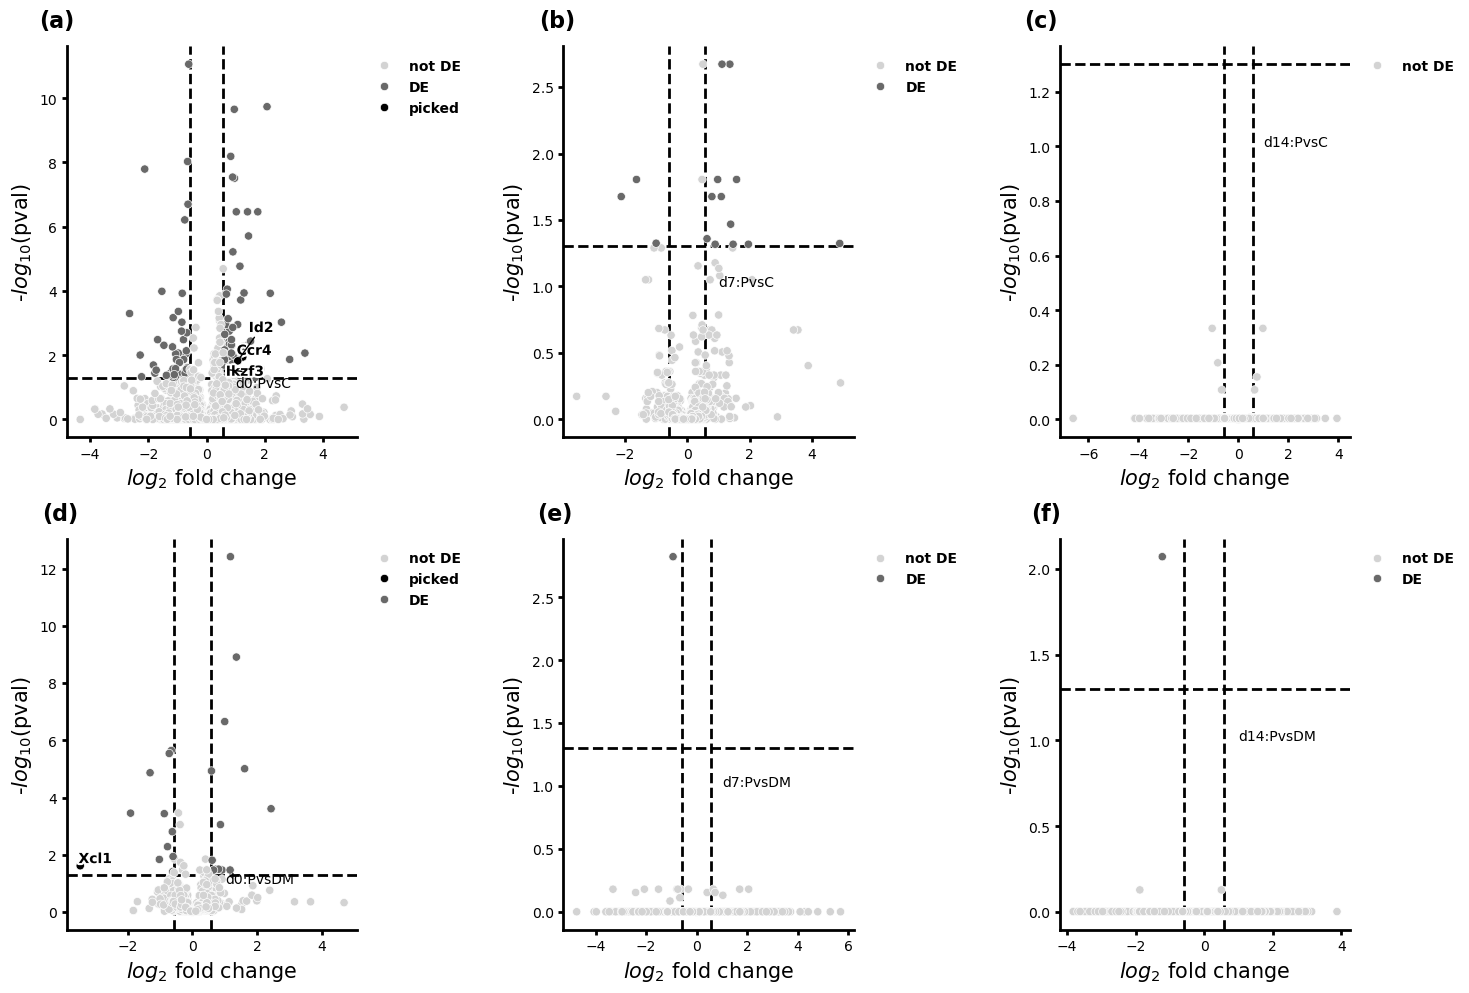

CD8.TEX


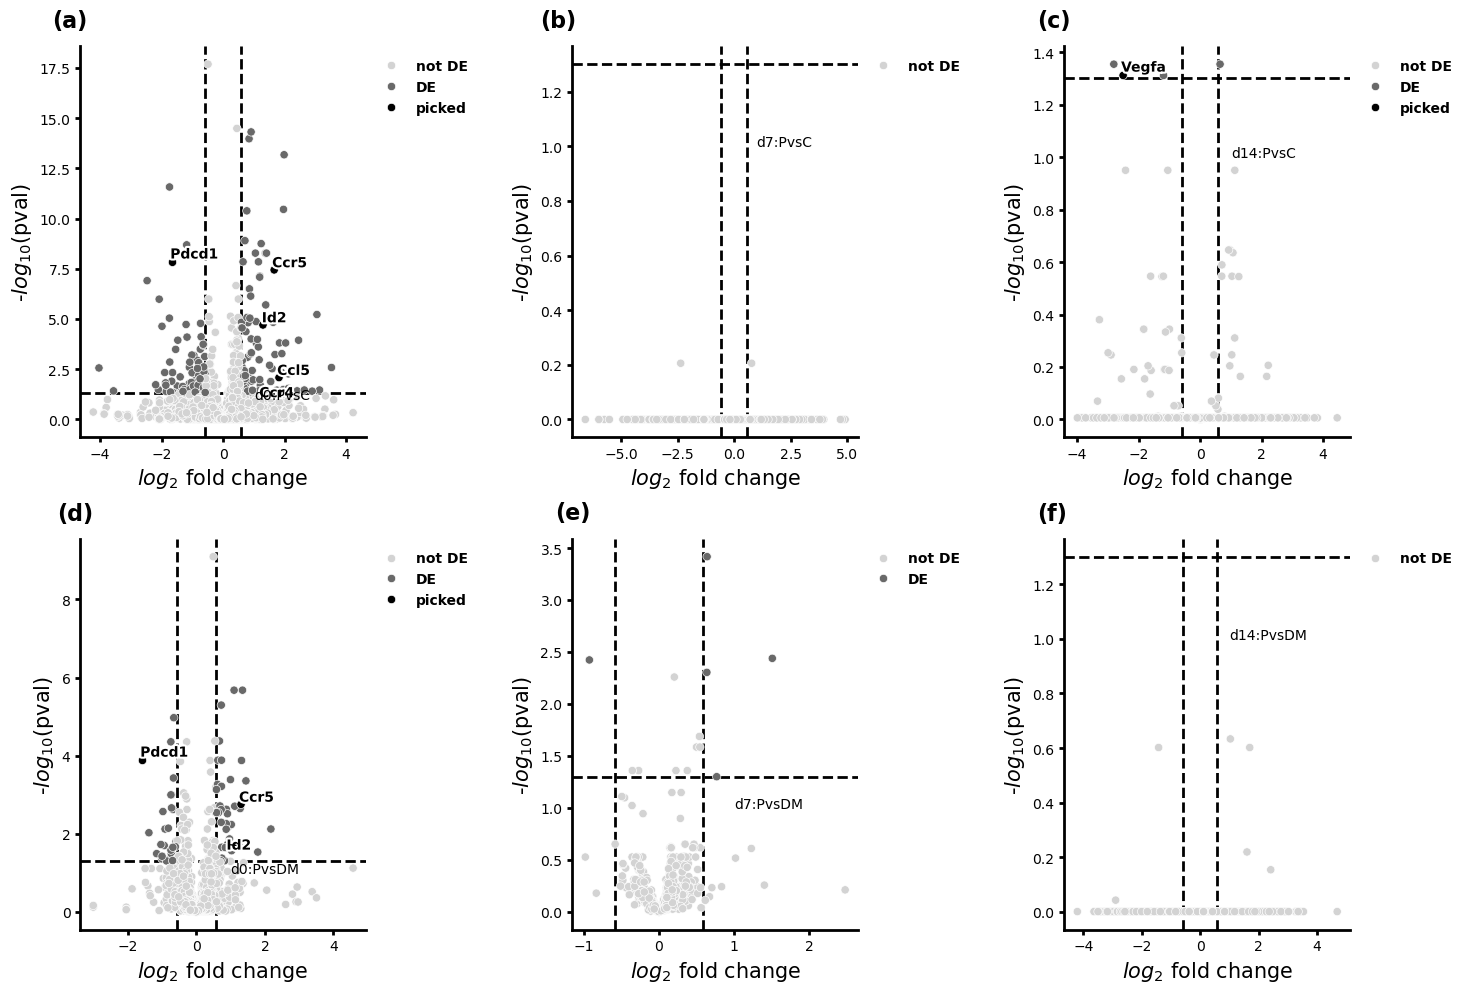

CD4.Th17


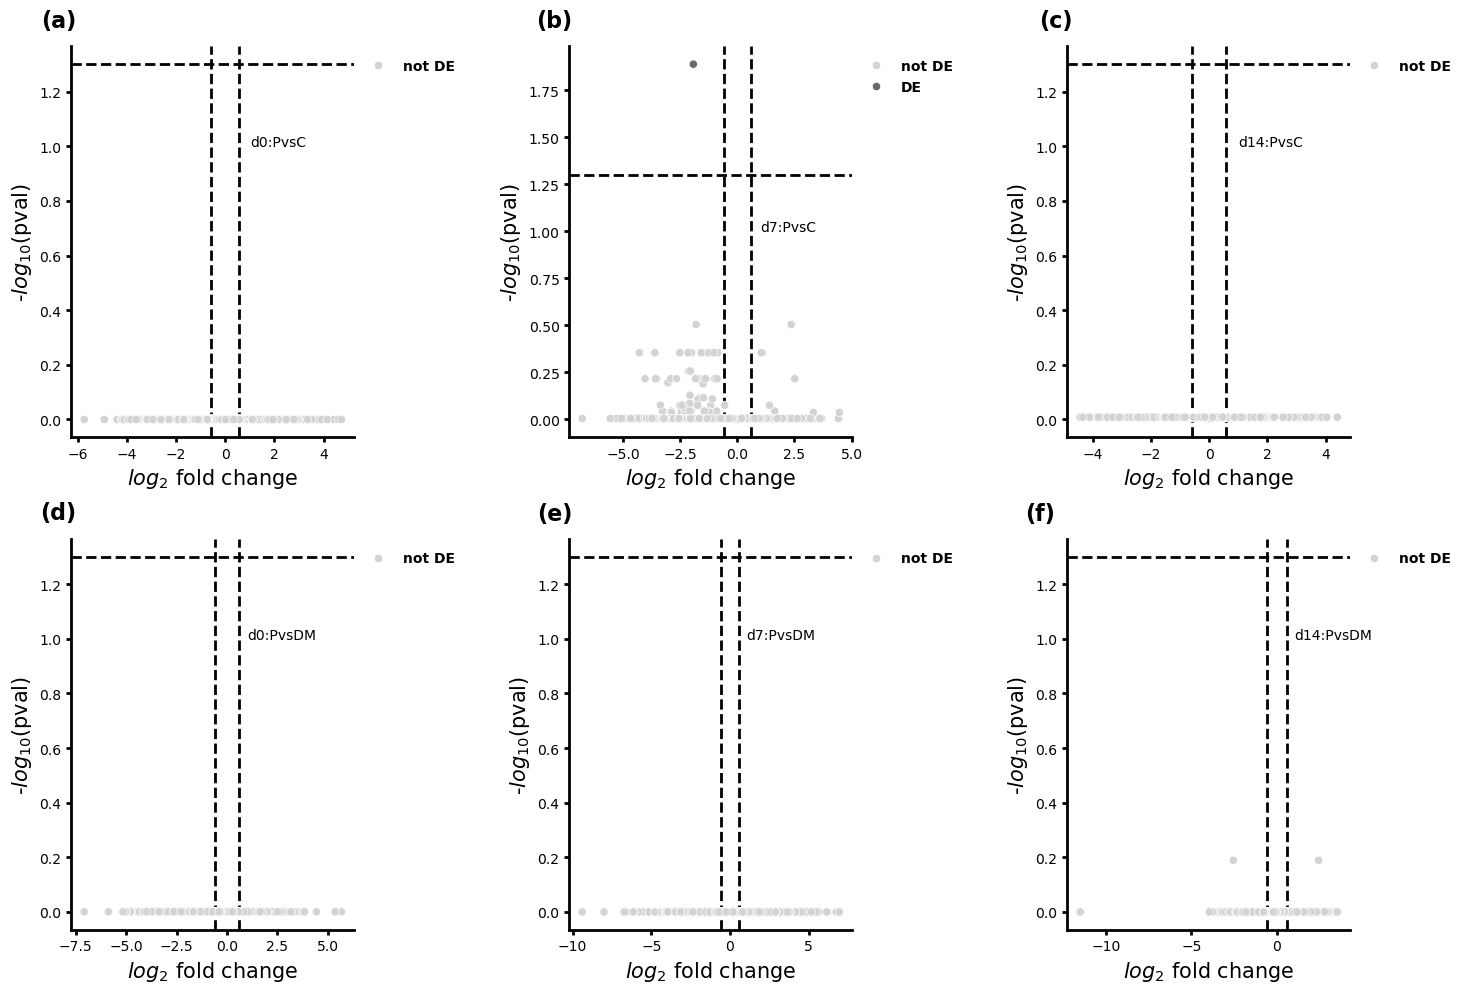

CD4.Treg
18 [-0.94214872 -0.7065919 ]
62 [0.7338877  0.37430519]


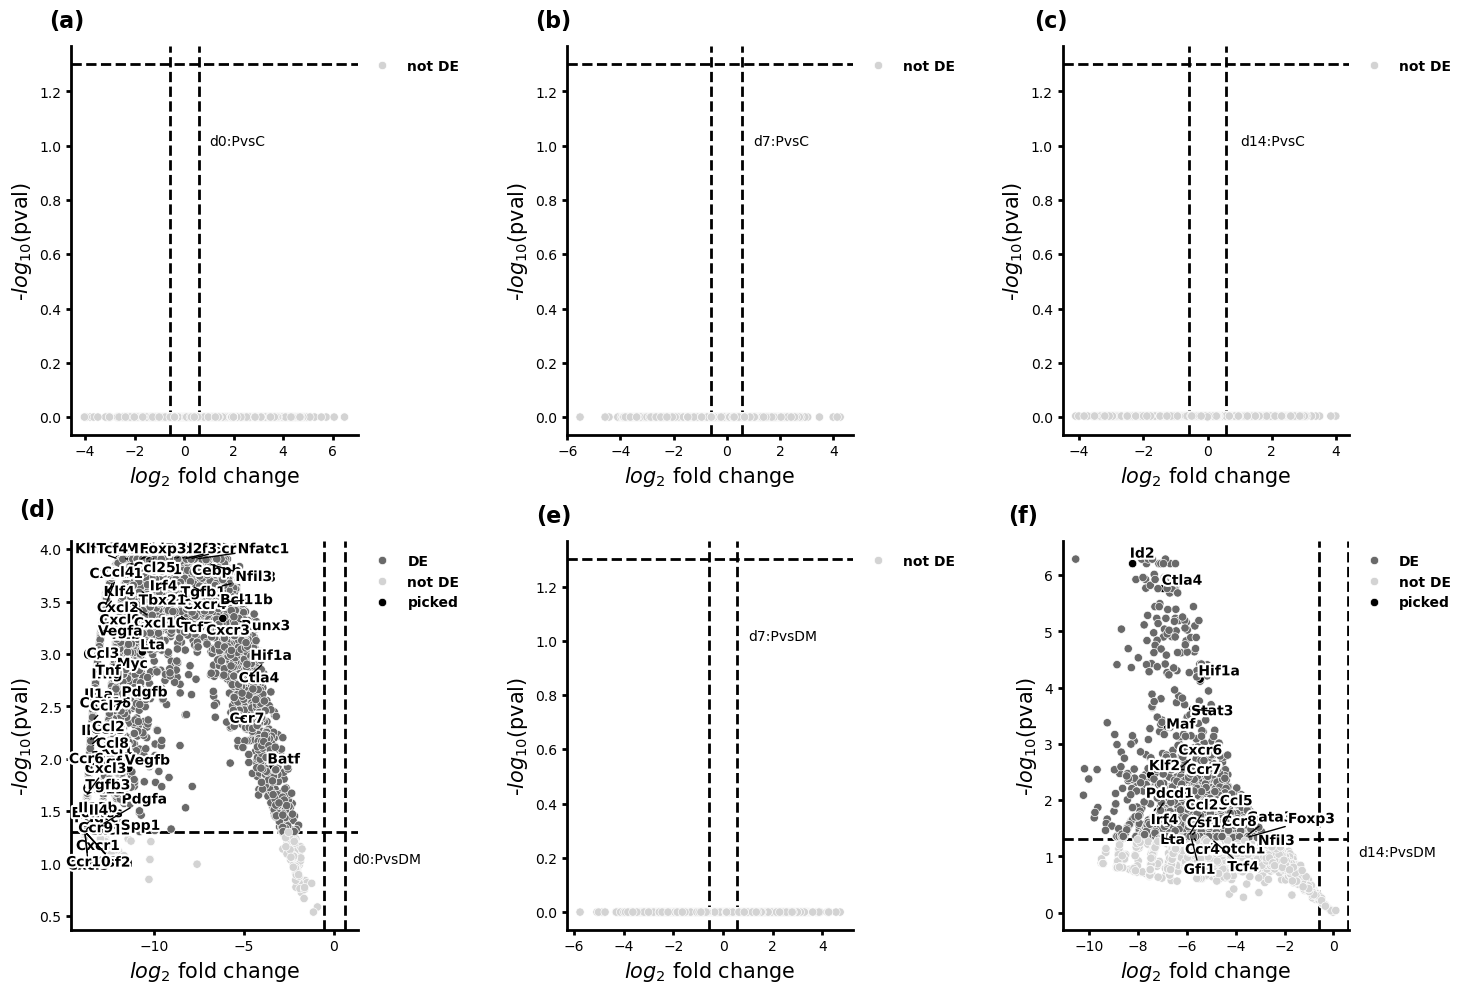

CD4.Tfh


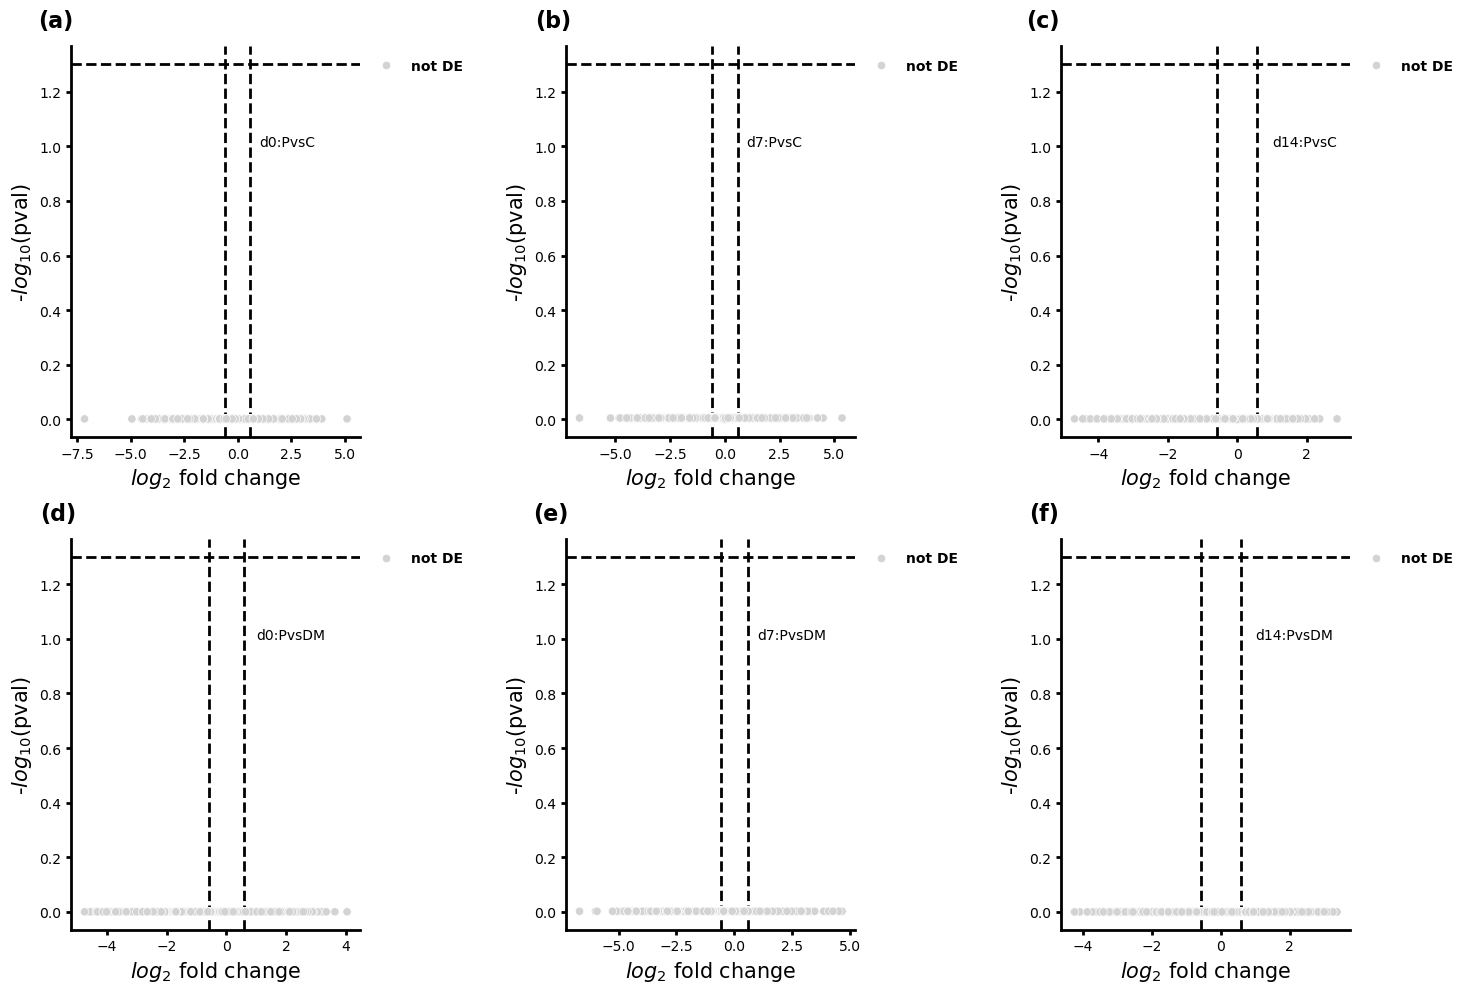

CD8.EM


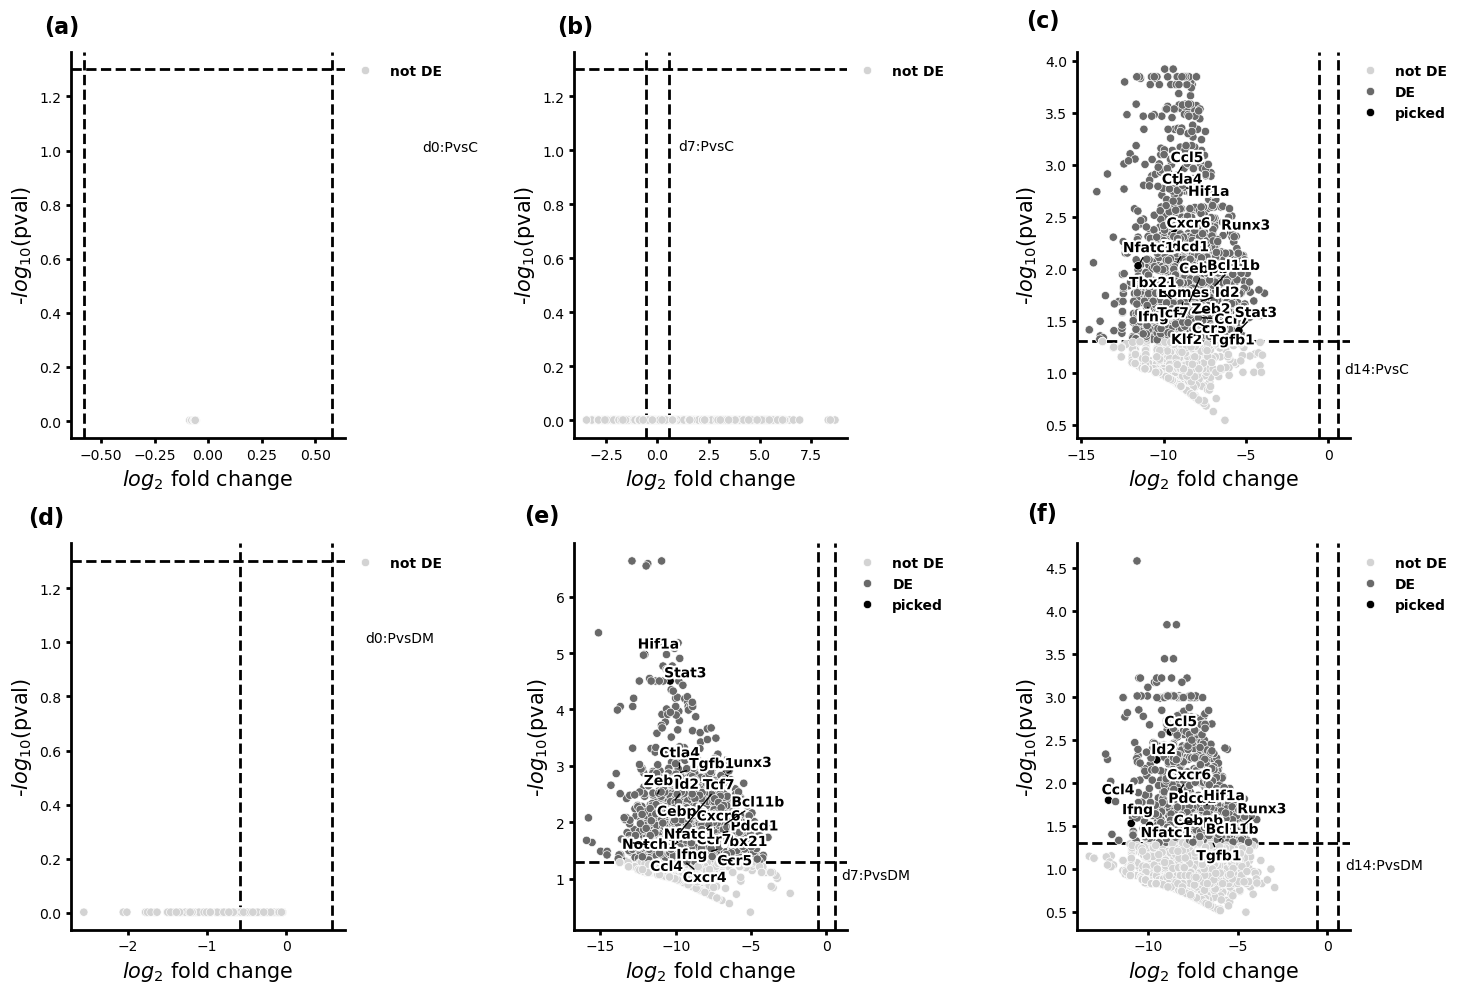

In [55]:
importlib.reload(dplt)
for celltype, typ in tc_sub_stats.items():
    print(celltype)
    # interesting_genes = ["Tnf", "Ifng", "Il2", "Gzmb", "Tbx21", "Foxp3", "Il4"]
    subplot_labels = list(string.ascii_lowercase[:6]) 
    # Create subplots (3 columns, 2 rows)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easier iteration
    # Loop through datasets and plot each in a subplot
    for i, key in enumerate(list(typ.keys())): 
        dplt.volcano(typ[key], symbol='index', log2fc_thresh=0.58, ax=axes[i], to_label=labels)  # Pass ax
        # Add subplot label in top-left corner of each plot
        x_min, _ = axes[i].get_xlim()  # Get x-axis limits
        y_max = axes[i].get_ylim()[1]  # Get top y-axis limit
        axes[i].text(x_min * 1.2, y_max * 1.1,  # Adjust position dynamically
                         f"({subplot_labels[i]})", fontsize=16, fontweight='bold',
                         ha="left", va="top")
        axes[i].text(1,1, f'{key}')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### first get raw count matrix again

In [ ]:

%R file_path <- "./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.RData"
%R load(file_path)
%R DefaultAssay(scgate.projected) <- "RNA"
# %R sbst <- subset(scgate.projected, subset = is.na(functional.cluster))
%R sbst <- subset(scgate.projected, cells = rownames(scgate.projected@meta.data)[!is.na(scgate.projected@meta.data$functional.cluster)])
%R print(sbst)
%R raw_mat <- t(GetAssayData(sbst, slot = "counts")) 
%R print(max(raw_mat))
%R -o raw_mat



An object of class Seurat 
34747 features across 3456 samples within 3 assays 
Active assay: RNA (33696 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: HTO, integrated
 2 dimensional reductions calculated: pca, umap
[1] 1501


'value'

: 

: 